In [4]:
#imports
import numpy as np
import torch as tr
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import sklearn.svm
from cvxopt.solvers import qp
from cvxopt import matrix as cvxmatrix
from cvxopt.solvers import qp, options


# Implementation

In [9]:
class svm_qp():
    """ Support Vector Machines via Quadratic Programming """
    options['show_progress'] = False
    
    def __init__(self, kernel='linear', kernelparameter=1., C=1.):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.C = C
        self.alpha_sv = None
        self.b = None
        self.X_sv = None
        self.Y_sv = None
    
    def fit(self, X, Y, kernel=False, kernelparameter=False, regularization=False):
        
        self.X_sv = X
        self.Y_sv = Y
        self.__ydim = Y.shape[0]
        
        # reshape ytrain
        self.Y_sv = self.Y_sv.reshape(self.__ydim,-1)

        self.kernelmatrix = buildKernel(self.X_sv.T, kernel = self.kernel, kernelparameter = self.kernelparameter)
        
        P = (self.Y_sv@self.Y_sv.T)*self.kernelmatrix
        q = -1*np.ones((self.__ydim,1)) #y_train has the same length as X_train
        A = self.Y_sv.T
        A = A.astype(np.double)
        b = 0
        if self.C is None: 
            # constraint for evrry every alpha: 0 =< alpha
            # use matrix notation
            # QP solver wants it: Gx =< h, where h expresses the 0 of the condition
            # to foollow the QP_solver formulation contraint in G expressed by -1
            G = -1*np.identity(self.__ydim)
            h = np.zeros(self.__ydim)
        else:
            # constraint for every alpha: 0 =< alpha =< C
            # use matrix notation
            # QP solver wants it: Gx =< h, hence h expresses the upper and lower bound of the condition -> h_size = 2n x 1
            # G of size 2n x n 
            # first n rows contain the constraint 0 =< alpha -> in G expressed by -1, in h with 0
            # second n rows contain the constraint alpha =< C -> in G expressed by 1, in h with C
            G = np.vstack((-1*np.identity(self.__ydim),np.identity(self.__ydim)))
            h = np.hstack((np.zeros(self.__ydim),self.C*np.ones(self.__ydim)))
        # this is already implemented so you don't have to
        # read throught the cvxopt manual
        alpha = np.array(qp(cvxmatrix(P, tc='d'),
                            cvxmatrix(q, tc='d'),
                            cvxmatrix(G, tc='d'),
                            cvxmatrix(h, tc='d'),
                            cvxmatrix(A, tc='d'),
                            cvxmatrix(b, tc='d'))['x']).flatten()
        # Support vectors have non zero lagrange multipliers and are smaller than C/m
        self.sv = np.logical_and(alpha > 1e-5, alpha < np.round(self.C,5)) #treshold 1e-5
        self.alpha_sv = alpha[self.sv]
        
        self.X_sv = self.X_sv[self.sv]
        self.Y_sv = self.Y_sv[self.sv]

        self.kernelmatrix = buildKernel(self.X_sv.T, kernel = self.kernel, kernelparameter = self.kernelparameter)

        #self.b = np.mean(self.Y_sv-(alpha.reshape(-1,1)*self.__ytrain).T@self.kernelmatrix)
        
        # use only sv 
        self.b = np.mean(self.Y_sv-(self.alpha_sv.reshape(-1,1)*self.Y_sv).T@(self.kernelmatrix))
        
    def predict(self, X):

        self.kernelmatrix = buildKernel(self.X_sv.T,X.T, kernel = self.kernel, kernelparameter = self.kernelparameter)
        #self.yhat = np.sign((self.alpha_sv.reshape(-1,1)*self.Y_sv).T @ self.kernelmatrix + self.b)
        self.yhat = ((self.alpha_sv.reshape(-1,1)*self.Y_sv).T @ self.kernelmatrix + self.b)

        return self.yhat
    
    def __linearKernel(self, Y):
        self.kernelmatrix = self.X_sv.dot(Y.T)

    def __polynomialKernel(self, Y):
        self.kernelmatrix = (self.X_sv.dot(Y.T) + 1) ** self.kernelparameter

    def __gaussianKernel(self, Y):
        X_len, X_width = self.X_sv.shape
        self.kernelmatrix = np.exp(-(
                    np.diagonal(self.X_sv.dot(self.X_sv.T)).reshape(X_len, 1) - 2 * self.X_sv.dot(
                Y.T) + np.diagonal(Y.dot(Y.T))) / (2 * (self.kernelparameter ** 2)))


In [10]:
""" ps4_implementation.py

PUT YOUR NAME HERE:
Boris Bubla
Leonard Paeleke


Complete the classes and functions
- svm_qp
- plot_svm_2d
- neural_network
Write your implementations in the given functions stubs!


(c) Felix Brockherde, TU Berlin, 2013
    Jacob Kauffmann, TU Berlin, 2019
"""
import scipy.linalg as la
import matplotlib.pyplot as plt
import sklearn.svm
from cvxopt.solvers import qp
from cvxopt import matrix as cvxmatrix
import numpy as np
import torch as tr
from scipy.stats import bernoulli


# This is already implemented for your convenience
class svm_sklearn():
    """ SVM via scikit-learn """
    def __init__(self, kernel='linear', kernelparameter=1., C=1.):
        if kernel == 'gaussian':
            kernel = 'rbf'
        self.clf = sklearn.svm.SVC(C=C,
                                   kernel=kernel,
                                   gamma=1./(1./2. * kernelparameter ** 2),
                                   degree=kernelparameter,
                                   coef0=kernelparameter)

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.X_sv = X[self.clf.support_, :]
        self.y_sv = y[self.clf.support_]

    def predict(self, X):
        return self.clf.decision_function(X)


# Assignment 2

def plot_boundary_2d(X, y, model):
    """
    Plots a 2 dimensional boundary of a model.

    Inputs:
    X = 2d data array (nx2)
    y = labels (nx1)
    model = model (typically SVM or neural net)
    """
    # 1. plot points X
    plt.scatter(X.T[0][np.argwhere(y == 1)], X.T[1][np.argwhere(y == 1)], c='b', label='Positive class')
    plt.scatter(X.T[0][np.argwhere(y == -1)], X.T[1][np.argwhere(y == -1)], c='r', label='Negative class')

    # 2. mark support vectors with a cross if svm
    if isinstance(model, svm_sklearn):
        plt.scatter(model.X_sv.T[0], model.X_sv.T[1], s=80, c='y', marker='x', label='Support vectors')

    # 3. plot separating hyperplane
    # 3a. create grid of predictions
    x_max = np.amax(X, axis=0)
    x_min = np.amin(X, axis=0)
    x0 = np.linspace(x_min[0], x_max[0], 50)
    x1 = np.linspace(x_min[1], x_max[1], 50)
    x0v, x1v = np.meshgrid(x0, x1)
    Xv = np.squeeze(np.array((x0v.reshape(2500, 1), x1v.reshape(2500, 1))))
    grid_pred = model.predict(Xv.T)
    # 3b plot level 0 contour line
    plt.contour(x0, x1, grid_pred.reshape(50, 50), levels=0)

    # format plot
    plt.ylabel('X1')
    plt.xlabel('X0')
    plt.title('2D visualisation of model classifications with a separating hyperplane')
    plt.legend()
    plt.show()


def sqdistmat(X, Y=False):
    if Y is False:
        X2 = sum(X**2, 0)[np.newaxis, :]
        D2 = X2 + X2.T - 2*np.dot(X.T, X)
    else:
        X2 = sum(X**2, 0)[:, np.newaxis]
        Y2 = sum(Y**2, 0)[np.newaxis, :]
        D2 = X2 + Y2 - 2*np.dot(X.T, Y)
    return D2


def buildKernel(X, Y=False, kernel='linear', kernelparameter=0):
    d, n = X.shape
    if Y is False:# Y.isinstance(bool) and
        Y = X
    if kernel == 'linear':
        K = np.dot(X.T, Y)
    elif kernel == 'polynomial':
        K = np.dot(X.T, Y) + 1
        K = K**kernelparameter
    elif kernel == 'gaussian':
        K = sqdistmat(X, Y)
        K = np.exp(K / (-2 * kernelparameter**2))
    else:
        raise Exception('unspecified kernel')
    return K


# provided stub
class neural_network():
    def __init__(self, layers=[2, 100, 2], scale=.1, p=.1, lr=.1, lam=.1):
        super().__init__()
        self.weights = tr.nn.ParameterList([tr.nn.Parameter(scale * tr.randn(m, n)) for m, n in zip(layers[:-1], layers[1:])])
        self.biases = tr.nn.ParameterList([tr.nn.Parameter(scale * tr.randn(n)) for n in layers[1:]])
        self.parameters = list(self.weights) + list(self.biases)

        self.p = p
        self.lr = lr
        self.lam = lam
        self.train = False

    def relu(self, X, W, b):
        # algorithm 15, pg 46 from guide.pdf
        if self.train:
            delta = bernoulli.rvs(1 - self.p,
                                  size=W.shape[1])  # sample 'out' many samples from Bernoulli distribution B(1-p)
            Z = tr.from_numpy(delta) * tr.max(tr.zeros(X.shape[0], W.shape[1]), tr.mm(X, W) + b)

        else:
            Z = tr.max(tr.zeros(X.shape[0], W.shape[1]), (1 - self.p) * tr.mm(X, W) + b)

        return Z

    def softmax(self, Z, W, b):
        # algorithm 16, pg 46 from guide.pdf
        Z = tr.mm(Z, W) + b
        y_hat = tr.div(tr.exp(Z).T, tr.sum(tr.exp(Z), dim=1)).T

        return y_hat

    def forward(self, X):
        # algorithm 14, pg 45 from guide.pdf
        X = tr.tensor(X, dtype=tr.float)
        Z = X
        # apply ReLU to all layers but the last
        for w, b in zip(self.weights[:len(self.weights) - 1],
                        self.biases[:len(self.biases) - 1]):  # iterate through L-1 layers
            Z = self.relu(Z, w, b)
        # apply softmax to last layer
        y_hat = self.softmax(Z, self.weights[len(self.weights) - 1], self.biases[len(self.biases) - 1])

        return y_hat

    def predict(self, X):
        return self.forward(X).detach().numpy()

    def loss(self, ypred, ytrue):
        # compute cross entropy loss according to pg47 from guide.pdf
        loss = (-1 / ytrue.shape[0]) * tr.sum(ytrue * tr.log(ypred))

        return loss

    def fit(self, X, y, nsteps=1000, bs=100, plot=False):
        X, y = tr.tensor(X), tr.tensor(y)
        optimizer = tr.optim.SGD(self.parameters, lr=self.lr, weight_decay=self.lam)

        I = tr.randperm(X.shape[0])
        n = int(np.ceil(.1 * X.shape[0]))
        Xtrain, ytrain = X[I[:n]], y[I[:n]]
        Xval, yval = X[I[n:]], y[I[n:]]

        Ltrain, Lval, Aval = [], [], []
        for i in range(nsteps):
            optimizer.zero_grad()
            I = tr.randperm(Xtrain.shape[0])[:bs]
            self.train = True
            output = self.loss(self.forward(Xtrain[I]), ytrain[I])
            self.train = False
            Ltrain += [output.item()]
            output.backward()
            optimizer.step()

            outval = self.forward(Xval)
            Lval += [self.loss(outval, yval).item()]
            Aval += [np.array(outval.argmax(-1) == yval.argmax(-1)).mean()]

        if plot:
            plt.plot(range(nsteps), Ltrain, label='Training loss')
            plt.plot(range(nsteps), Lval, label='Validation loss')
            plt.plot(range(nsteps), Aval, label='Validation acc')
            plt.legend()
            plt.show()



In [11]:
#testing relu
def relu(p, X, W, b):
    # YOUR CODE HERE!
    #algorithm 15, pg 46 from guide.pdf
    if train:
        delta = bernoulli.rvs(1-p, size=W.shape[1]) #sample 'out' many samples from Bernoulli distribution B(1-p) 
        Z = tr.from_numpy(delta) * tr.max(tr.zeros(X.shape[0],W.shape[1]),tr.mm(X,W)+b)
        #Z = delta.detach().numpy() * np.maximum(0,torch.mm(X,W)+b)
        
    else:
        Z = tr.max(tr.zeros(X.shape[0],W.shape[1]),(1-p)*tr.mm(X,W)+b)
            
    return Z

In [12]:
#testing softmax
def softmax(Z, W, b):
    # algorithm 16, pg 46 from guide.pdf
    Z = torch.mm(Z,W)+b
    y_hat = torch.div(torch.exp(Z).T,torch.sum(torch.exp(Z),dim=1)).T #can't specify division dim so double transpose to get desired behaviour
    return y_hat

In [13]:
#testing forward
def forward(weights,biases, X):
    # algorithm 14, pg 45 from guide.pdf
    X = torch.tensor(X, dtype=torch.float)
    Z = X
    #apply ReLU to all layers but the last
    for w, b in zip(weights[:len(weights)-1], biases[:len(biases)-1]): #iterate through L-1 layers
        Z = relu(p, Z, w, b)
    #apply softmax to last layer
    y_hat = softmax(Z, weights[len(weights)-1], biases[len(biases)-1])
    
    return y_hat

In [34]:
def loss(ypred, ytrue):
    # compute cross entropy loss according to pg47 from guide.pdf
    loss = (-1/ytrue.shape[0])*tr.sum(ytrue*tr.log(ypred))
    
    return loss

In [15]:
#Assignment 2

def plot_boundary_2d(X, y, model):
    """
    Plots a 2 dimensional boundary of a model.
    
    Inputs:
    X = 2d data array (nx2) 
    y = labels (nx1)
    model = model (typically SVM or neural net)
    """
    #1. plot points X
    plt.scatter(X.T[0][np.argwhere(y==1)],X.T[1][np.argwhere(y==1)],c='b',label='Positive class')
    plt.scatter(X.T[0][np.argwhere(y==-1)],X.T[1][np.argwhere(y==-1)],c='r',label='Negative class')
    
    #2. mark support vectors with a cross if SVM
    if isinstance(model, svm_sklearn):
        plt.scatter(model.X_sv.T[0],model.X_sv.T[1],s=80,c='y',marker='x',label='Support vectors')
    
    #3. plot separating hyperplane
    #3a. create grid of predictions
    x_max = np.amax(X,axis=0)
    x_min = np.amin(X,axis=0)
    x0 = np.linspace(x_min[0],x_max[0],50)
    x1 = np.linspace(x_min[1],x_max[1],50)
    x0v, x1v = np.meshgrid(x0, x1)
    Xv = np.squeeze(np.array((x0v.reshape(2500,1),x1v.reshape(2500,1))))
    grid_pred = model.predict(Xv.T)
    #3b plot level 0 contour line
    plt.contour(x0,x1,grid_pred.reshape(50,50),levels=0)
    
    #format plot
    plt.ylabel('X1')
    plt.xlabel('X0')
    plt.title('2D visualisation of model classifications with a separating hyperplane')
    plt.legend()
    

In [16]:
    #COPY OVER TESTING FUNCTIONS
    
    def test_svm_qp(self):
        C = imp.svm_qp(kernel='linear', C=1.)
        np.random.seed(1)
        X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_tr = np.array([1] * 30 + [-1] * 30)
        X_te = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_te = np.array([1] * 30 + [-1] * 30)
        C.fit(X_tr, Y_tr)
        Y_pred = C.predict(X_te)
        loss = float(np.sum(np.sign(Y_te) != np.sign(Y_pred)))/float(len(Y_te))
        imp.plot_boundary_2d(X_tr, Y_tr, C)
        print('test case loss', loss)
        self.assertTrue(loss < 0.25, msg='svm_qp: Error. The loss is %.2f and should be below 0.25' % loss)

In [17]:
    def test_plot_boundary_2d(self):
        C = imp.svm_sklearn(kernel='gaussian', C=1.)
        np.random.seed(1)
        X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_tr = np.array([1] * 30 + [-1] * 30)
        C.fit(X_tr, Y_tr)
        imp.plot_boundary_2d(X_tr, Y_tr, C)

In [18]:
    def test_neural_network(self):
        X = tr.tensor([[1, 1], [0, 0]], dtype=tr.float)
        y = tr.tensor([[0, 1], [1, 0]], dtype=tr.int)
        W = tr.tensor([[1, .2], [.5, 1]], dtype=tr.float)
        b = tr.tensor([-1, -1], dtype=tr.float)
        m = imp.neural_network(layers=[2,2,2], p=0, lam=0)

        m.fit(X, y, nsteps=1, bs=1, plot=False)

        relu_out = tr.tensor([[.5,.2],[0, 0]])
        self.assertTrue(np.allclose(m.relu(X, W, b), relu_out), msg='neural_network: Error. ReLU output not correct')

        softmax_out = np.array([[0.57444252, 0.42555748], [.5, .5]])
        self.assertTrue(np.allclose(m.softmax(relu_out, W, b), softmax_out), msg='neural_network: Error. Softmax output not correct')

        m.weights = tr.nn.ParameterList([tr.nn.Parameter(W), tr.nn.Parameter(W)])
        m.biases = tr.nn.ParameterList([tr.nn.Parameter(b), tr.nn.Parameter(b)])
        loss_out = 0.7737512125142362
        out = m.forward(X)
        loss = m.loss(out, y).item()
        self.assertTrue(np.isclose(loss_out, loss), msg='neural_network: Error. Loss output not correct')
        self.assertTrue(np.allclose(out.detach().numpy(), softmax_out), msg='neural_network: Error. Network output not correct')

    def test_nn_fit(self):
        np.random.seed(1)
        X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_tr = np.array([[1, 0]] * 30 + [[0, 1]] * 30)
        X_te = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_te = np.array([[1, 0]] * 30 + [[0, 1]] * 30)

        m = imp.neural_network(layers=[2, 100, 2], lr=.1, p=.04, lam=.0)
        m.fit(X_tr, Y_tr, nsteps=1000, bs=20, plot=True)

        Y_pred = m.predict(X_te)
        loss = (Y_pred.argmax(-1) != Y_te.argmax(-1)).mean()
        imp.plot_boundary_2d(X_tr, (-Y_tr).argmax(1), m)
        print('test case loss', loss)
        self.assertTrue(loss < 0.25, msg='neural_network: Error. The loss is %.2f and should be below 0.25' % loss)
        

In [19]:
# cv function from assignment 3
from tqdm import tqdm
import itertools as it
import random



def mean_absolute_error(y_true, y_pred):
    '''
    your code here
    '''
    loss = np.mean(abs(y_pred-y_true))
    return loss

def zero_one_loss(y_true, y_pred):
    '''
    Applies a the zero one loss function to predictions.

    Input:
    y_true = the true data labels (nx1)
    y_pred = the predicted data labels (nx1)

    Output:
    loss = the zero one loss
    '''
    loss = np.count_nonzero(y_true != np.sign(y_pred))
    return loss


def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    '''
    This function applies a cross validation procedure with a specified loss function and model parameters.

    Inputs:
    X = X training data (nxd)
    y = y training data (nxe)
    method = model
    params = the model parameters: the 'kernel', the 'kernelparameter' and 'regularisation' term.
    loss_function = the loss function to be used to calculate error.
    nfolds = number of equal sized folds
    nrepetitions = number of repetitions

    Outputs:
    method = the model object with the best parameters and cvloss.
    '''
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        e = 0
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int'))
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(model.cvloss))
        if e < method.cvloss:
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
            
    return method



# Application

In [ ]:
def assignment_6_svm():
    #Assignment 6

    #cwd = os.getcwd()
    #print(cwd)
    #file_name = 'usps.mat'
    #path_to_data = cwd + file_name
    path_to_data = 'C:/Users/Boris/Desktop/ML Lab Course/ML Lab Assignments/assignment4/stubs/usps.mat'
    assert os.path.exists(path_to_data), "The path to the data does not exist."
    data = sio.loadmat(path_to_data)
    data_labels = data['data_labels']
    usps_data = data['data_patterns'].T
    
    X = usps_data
    y = data_labels
    
    # 6.1 Fivefold Cross validation - SVM

    #select 2005 random datapoints, so that we have equally sized folds
    X_pos = np.linspace(0,len(X)-1, len(X))
    random.Random(2).shuffle(X_pos)
    X = X[X_pos[:2005].astype('int')]
    y = y.T[X_pos[:2005].astype('int')]
    print(X.shape)
    print(y.shape)

    #train test split so we can estimate test error
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)


    #parameteres to search from
    params_lst = [{ 'kernel': ['gaussian'], 'kernelparameter': [0.1,0.5,0.9], 'regularization': [0.25,0.5,0.75,1,1.25,1.5,1.75] },
         { 'kernel': ['polynomial'], 'kernelparameter': [1,2,3], 'regularization': [0.25,0.5,0.75,1,1.25,1.5,1.75] },
         { 'kernel': ['linear'], 'kernelparameter': [0], 'regularization': [0.25,0.5,0.75,1,1.25,1.5,1.75] }]


    svm_classifiers = []
    #separate ylabels for one-vs-rest classification by looping through digit
    #for each digit
    for digit in y_tr.T:
        candidate_classifiers = []
        candidate_losses = []
        #for each parameter set
        for params in params_lst:
            #use cross entropy loss
            cvsvm = cv(X_tr, digit, svm_qp, params, loss_function=zero_one_loss, nfolds=4, nrepetitions=1)
            print(cvsvm)
            print(cvsvm.cvloss)
            print(cvsvm.__params)
            candidate_classifiers.append(cvsvm)
            candidate_losses.append(cvsvm.cvloss)
        
        #select classifier with lowest cv loss
        svm_classifiers.append(candidate_classifiers[np.argmin(candidate_losses)])
    

    results = [{'kernel':'polynomial','kernelparameter':2,'C':1.75},
           {'kernel':'polynomial','kernelparameter':2,'C':1.25},
           {'kernel':'polynomial','kernelparameter':2,'C':1},
           {'kernel':'polynomial','kernelparameter':2,'C':[0.5]},
           {'kernel':'polynomial','kernelparameter':2,'C':[1.75]},
           {'kernel':'polynomial','kernelparameter':2,'C':[1.25]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[1.5]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[0.75]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[0.5]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[0.5]},]


    fig = plt.figure(figsize=(16, 18))
    fig.suptitle('Plot of 5 randomly chosen support vectors (columns) for digits 0-9 (rows)',fontsize=20)
    gs = fig.add_gridspec(10, 5)
    for idx, params in enumerate(results):
        #print(params['kernel'])
        svm = svm_qp(kernel=params['kernel'],kernelparameter=params['kernelparameter'],C=params['C'])
        svm.fit(X_tr,y_tr.T[idx])
        #print(svm.X_sv)
        #print(svm.X_sv.shape)
    
        #select 5 random SVs
        X_pos = np.linspace(0,len(svm.X_sv)-1, len(svm.X_sv))
        random.Random(3).shuffle(X_pos)
        X = svm.X_sv[X_pos[:5].astype('int')]
    
        for idx2, sv in enumerate(X):
            f_ax1 = fig.add_subplot(gs[idx, idx2])
            plt.imshow(sv.reshape(16,16),cmap='gray')
        
    
    

In [ ]:
def assignment_6_neuralnet():
    #cwd = os.getcwd()
    #print(cwd)
    #file_name = 'usps.mat'
    #path_to_data = cwd + file_name
    path_to_data = 'C:/Users/Boris/Desktop/ML Lab Course/ML Lab Assignments/assignment4/stubs/usps.mat'
    assert os.path.exists(path_to_data), "The path to the data does not exist."
    data = sio.loadmat(path_to_data)
    data_labels = data['data_labels']
    
    X = usps_data
    y = data_labels
    y = np.where(y==-1,0,y)



    #select 2005 random datapoints, so that we have equally sized folds
    X_pos = np.linspace(0,len(X)-1, len(X))
    random.Random(2).shuffle(X_pos)
    X = X[X_pos[:2005].astype('int')]
    y = y.T[X_pos[:2005].astype('int')]
    #print(X.shape)
    #print(y.shape)

    #parameters to search from
    params = { 'layers': [[256,20,200,10]], 'p': [0.05,0.1,0.15,0.2], 'lam': [0.0001,0.001,0.01,0.1], 'lr': [0.01,0.05,0.1] }

    #try 'em out
    #cross entropy loss for classification
    cvnn = cv_nn(X, y, neural_network, params, loss_function=loss, nfolds=5, nrepetitions=1)
    
    nn = neural_network(cvnn.__params[0], scale=0.1, p=cvnn.__params[1], lr=cvnn.__params[3], lam=cvnn.__params[2])
    nn.fit(X,y)
    
    nn.weights[0].T.shape

    fig = plt.figure(figsize=(12,16))
    gs = fig.add_gridspec(5, 4)
    fig.suptitle('Plots of 20 weight vectors from first layer of neural net',fontsize=20)

    for idx, weight in enumerate(nn.weights[0].T):
        #print(weight.shape)
        f_ax1 = fig.add_subplot(gs[idx-1])
        plt.title('Weight vector %d'%idx)
        plt.imshow(weight.detach().numpy().reshape(16,16),cmap='gray')

    

In [85]:
#Assignment 6
import os
import scipy.io as sio
#cwd = os.getcwd()
#print(cwd)
#file_name = 'usps.mat'
#path_to_data = cwd + file_name
path_to_data = 'C:/Users/Boris/Desktop/ML Lab Course/ML Lab Assignments/assignment4/stubs/usps.mat'
assert os.path.exists(path_to_data), "The path to the data does not exist."
data = sio.loadmat(path_to_data)
data_labels = data['data_labels']
usps_data = data['data_patterns'].T


In [86]:
X = usps_data
y = data_labels

In [87]:
# 6.1 Fivefold Cross validation - SVM

#select 2005 random datapoints, so that we have equally sized folds
X_pos = np.linspace(0,len(X)-1, len(X))
random.Random(2).shuffle(X_pos)
X = X[X_pos[:2005].astype('int')]
y = y.T[X_pos[:2005].astype('int')]
print(X.shape)
print(y.shape)

#train test split so we can estimate test error
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)


#parameteres to search from
params_lst = [{ 'kernel': ['gaussian'], 'kernelparameter': [0.1,0.5,0.9], 'regularization': [0.25,0.5,0.75,1,1.25,1.5,1.75] },
         { 'kernel': ['polynomial'], 'kernelparameter': [1,2,3], 'regularization': [0.25,0.5,0.75,1,1.25,1.5,1.75] },
         { 'kernel': ['linear'], 'kernelparameter': [0], 'regularization': [0.25,0.5,0.75,1,1.25,1.5,1.75] }]


svm_classifiers = []
#separate ylabels for one-vs-rest classification by looping through digit
#for each digit
for digit in y_tr.T:
    candidate_classifiers = []
    candidate_losses = []
    #for each parameter set
    for params in params_lst:
        #use cross entropy loss
        cvsvm = cv(X_tr, digit, svm_qp, params, loss_function=zero_one_loss, nfolds=4, nrepetitions=1)
        print(cvsvm)
        print(cvsvm.cvloss)
        print(cvsvm.__params)
        candidate_classifiers.append(cvsvm)
        candidate_losses.append(cvsvm.cvloss)
        
    #select classifier with lowest cv loss
    svm_classifiers.append(candidate_classifiers[np.argmin(candidate_losses)])
    


        
    

(2005, 256)
(2005, 10)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:06<02:04,  6.23s/it]





 10%|▉         | 2/21 [00:13<02:02,  6.47s/it]





 14%|█▍        | 3/21 [00:20<02:00,  6.69s/it]





 19%|█▉        | 4/21 [00:27<01:57,  6.89s/it]





 24%|██▍       | 5/21 [00:34<01:49,  6.87s/it]





 29%|██▊       | 6/21 [00:41<01:40,  6.72s/it]





 33%|███▎      | 7/21 [00:47<01:35,  6.80s/it]





 38%|███▊      | 8/21 [00:55<01:30,  7.00s/it]





 43%|████▎     | 9/21 [01:02<01:25,  7.09s/it]





 48%|████▊     | 10/21 [01:09<01:17,  7.02s/it]





 52%|█████▏    | 11/21 [01:16<01:09,  6.99s/it]





 57%|█████▋    | 12/21 [01:22<01:00,  6.68s/it]





 62%|██████▏   | 13/21 [01:28<00:51,  6.46s/it]





 67%|██████▋   | 14/21 [01:34<00:44,  6.33s/it]





 71%|███████▏  | 15/21 [01:42<00:41,  6.96s/it]





 76%|███████▌  | 16/21 [01:50<00:36,  7.21s/it]





 81%|████████  | 17/21 [01:57<00:28,  7.15s/it]





 86%|████████▌ | 18/21 [02:04<00:21,  7.17s/it]





 90%|

<class '__main__.svm_qp'>
68.75
('gaussian', 0.9, 1.5)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:10<03:20, 10.02s/it]





 10%|▉         | 2/21 [00:20<03:10, 10.04s/it]





 14%|█▍        | 3/21 [00:30<02:59,  9.99s/it]





 19%|█▉        | 4/21 [00:40<02:50, 10.06s/it]





 24%|██▍       | 5/21 [00:50<02:40, 10.06s/it]





 29%|██▊       | 6/21 [00:59<02:28,  9.92s/it]





 33%|███▎      | 7/21 [01:10<02:20, 10.03s/it]





 38%|███▊      | 8/21 [01:21<02:17, 10.55s/it]





 43%|████▎     | 9/21 [01:33<02:09, 10.83s/it]





 48%|████▊     | 10/21 [01:44<02:01, 11.04s/it]





 52%|█████▏    | 11/21 [01:56<01:52, 11.23s/it]





 57%|█████▋    | 12/21 [02:08<01:42, 11.41s/it]





 62%|██████▏   | 13/21 [02:19<01:31, 11.46s/it]





 67%|██████▋   | 14/21 [02:31<01:21, 11.59s/it]C:\Users\Boris\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Boris\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: inva

<class '__main__.svm_qp'>
3.5
('polynomial', 2, 1.75)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:11<01:06, 11.02s/it]





 29%|██▊       | 2/7 [00:22<00:55, 11.03s/it]





 43%|████▎     | 3/7 [00:33<00:44, 11.01s/it]





 57%|█████▋    | 4/7 [00:44<00:33, 11.23s/it]





 71%|███████▏  | 5/7 [00:55<00:22, 11.09s/it]





 86%|████████▌ | 6/7 [01:06<00:11, 11.18s/it]





100%|██████████| 7/7 [01:18<00:00, 11.35s/it]

<class '__main__.svm_qp'>
7.0
('linear', 0, 0.75)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:08<02:43,  8.16s/it]





 10%|▉         | 2/21 [00:16<02:34,  8.12s/it]





 14%|█▍        | 3/21 [00:24<02:25,  8.07s/it]





 19%|█▉        | 4/21 [00:32<02:16,  8.03s/it]





 24%|██▍       | 5/21 [00:40<02:09,  8.08s/it]





 29%|██▊       | 6/21 [00:47<01:56,  7.76s/it]





 33%|███▎      | 7/21 [00:56<01:53,  8.10s/it]





 38%|███▊      | 8/21 [01:03<01:42,  7.90s/it]





 43%|████▎     | 9/21 [01:12<01:37,  8.08s/it]





 48%|████▊     | 10/21 [01:20<01:29,  8.16s/it]





 52%|█████▏    | 11/21 [01:28<01:20,  8.01s/it]





 57%|█████▋    | 12/21 [01:36<01:12,  8.08s/it]





 62%|██████▏   | 13/21 [01:43<01:03,  7.88s/it]





 67%|██████▋   | 14/21 [01:51<00:54,  7.74s/it]





 71%|███████▏  | 15/21 [02:00<00:48,  8.16s/it]





 76%|███████▌  | 16/21 [02:08<00:41,  8.30s/it]





 81%|████████  | 17/21 [02:17<00:33,  8.42s/it]





 86%|████████▌ | 18/21 [02:25<00:25,  8.36s/it]





 90%|

<class '__main__.svm_qp'>
12.5
('gaussian', 0.9, 1.5)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:12<04:05, 12.28s/it]





 10%|▉         | 2/21 [00:25<04:00, 12.64s/it]





 14%|█▍        | 3/21 [00:39<03:54, 13.03s/it]





 19%|█▉        | 4/21 [00:52<03:40, 12.96s/it]





 24%|██▍       | 5/21 [01:06<03:32, 13.26s/it]





 29%|██▊       | 6/21 [01:20<03:24, 13.61s/it]





 33%|███▎      | 7/21 [01:35<03:13, 13.79s/it]





 38%|███▊      | 8/21 [01:46<02:50, 13.15s/it]





 43%|████▎     | 9/21 [01:58<02:31, 12.62s/it]





 48%|████▊     | 10/21 [02:09<02:14, 12.26s/it]





 52%|█████▏    | 11/21 [02:21<02:00, 12.09s/it]





 57%|█████▋    | 12/21 [02:32<01:46, 11.86s/it]





 62%|██████▏   | 13/21 [02:43<01:33, 11.68s/it]





 67%|██████▋   | 14/21 [02:55<01:21, 11.60s/it]





 71%|███████▏  | 15/21 [03:07<01:10, 11.73s/it]





 76%|███████▌  | 16/21 [03:19<00:59, 11.90s/it]





 81%|████████  | 17/21 [03:31<00:48, 12.04s/it]





 86%|████████▌ | 18/21 [03:44<00:36, 12.23s/it]





 90%|

<class '__main__.svm_qp'>
1.75
('polynomial', 2, 1.25)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:12<01:15, 12.58s/it]





 29%|██▊       | 2/7 [00:25<01:02, 12.60s/it]





 43%|████▎     | 3/7 [00:38<00:51, 12.79s/it]





 57%|█████▋    | 4/7 [00:52<00:39, 13.09s/it]





 71%|███████▏  | 5/7 [01:06<00:26, 13.37s/it]





 86%|████████▌ | 6/7 [01:19<00:13, 13.41s/it]





100%|██████████| 7/7 [01:33<00:00, 13.53s/it]

<class '__main__.svm_qp'>
2.5
('linear', 0, 1.5)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:08<02:54,  8.72s/it]





 10%|▉         | 2/21 [00:16<02:41,  8.50s/it]





 14%|█▍        | 3/21 [00:24<02:30,  8.36s/it]





 19%|█▉        | 4/21 [00:32<02:18,  8.16s/it]





 24%|██▍       | 5/21 [00:40<02:08,  8.02s/it]





 29%|██▊       | 6/21 [00:47<01:58,  7.88s/it]





 33%|███▎      | 7/21 [00:55<01:49,  7.84s/it]





 38%|███▊      | 8/21 [01:03<01:43,  7.94s/it]





 43%|████▎     | 9/21 [01:11<01:35,  7.99s/it]





 48%|████▊     | 10/21 [01:20<01:29,  8.12s/it]





 52%|█████▏    | 11/21 [01:27<01:20,  8.02s/it]





 57%|█████▋    | 12/21 [01:35<01:11,  7.90s/it]





 62%|██████▏   | 13/21 [01:42<01:01,  7.67s/it]





 67%|██████▋   | 14/21 [01:49<00:51,  7.35s/it]





 71%|███████▏  | 15/21 [01:59<00:48,  8.10s/it]





 76%|███████▌  | 16/21 [02:08<00:41,  8.39s/it]





 81%|████████  | 17/21 [02:16<00:33,  8.49s/it]





 86%|████████▌ | 18/21 [02:25<00:25,  8.43s/it]





 90%|

<class '__main__.svm_qp'>
40.0
('gaussian', 0.9, 1.75)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:11<03:54, 11.74s/it]





 10%|▉         | 2/21 [00:22<03:39, 11.56s/it]





 14%|█▍        | 3/21 [00:34<03:26, 11.50s/it]





 19%|█▉        | 4/21 [00:45<03:13, 11.35s/it]





 24%|██▍       | 5/21 [00:56<03:00, 11.26s/it]





 29%|██▊       | 6/21 [01:07<02:46, 11.12s/it]





 33%|███▎      | 7/21 [01:18<02:37, 11.26s/it]





 38%|███▊      | 8/21 [01:30<02:28, 11.43s/it]





 43%|████▎     | 9/21 [01:45<02:30, 12.51s/it]





 48%|████▊     | 10/21 [01:57<02:15, 12.29s/it]





 52%|█████▏    | 11/21 [02:09<02:01, 12.13s/it]





 57%|█████▋    | 12/21 [02:20<01:47, 11.93s/it]





 62%|██████▏   | 13/21 [02:32<01:34, 11.84s/it]





 67%|██████▋   | 14/21 [02:43<01:22, 11.73s/it]





 71%|███████▏  | 15/21 [02:54<01:09, 11.61s/it]





 76%|███████▌  | 16/21 [03:06<00:58, 11.62s/it]





 81%|████████  | 17/21 [03:18<00:46, 11.70s/it]





 86%|████████▌ | 18/21 [03:30<00:35, 11.94s/it]





 90%|

<class '__main__.svm_qp'>
8.5
('polynomial', 2, 1)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:11<01:09, 11.59s/it]





 29%|██▊       | 2/7 [00:22<00:57, 11.43s/it]





 43%|████▎     | 3/7 [00:33<00:45, 11.39s/it]





 57%|█████▋    | 4/7 [00:45<00:34, 11.46s/it]





 71%|███████▏  | 5/7 [00:56<00:22, 11.37s/it]





 86%|████████▌ | 6/7 [01:08<00:11, 11.52s/it]





100%|██████████| 7/7 [01:19<00:00, 11.34s/it]

<class '__main__.svm_qp'>
14.0
('linear', 0, 1)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:08<02:51,  8.57s/it]





 10%|▉         | 2/21 [00:16<02:40,  8.46s/it]





 14%|█▍        | 3/21 [00:24<02:28,  8.25s/it]





 19%|█▉        | 4/21 [00:32<02:18,  8.14s/it]





 24%|██▍       | 5/21 [00:40<02:10,  8.15s/it]





 29%|██▊       | 6/21 [00:48<02:02,  8.14s/it]





 33%|███▎      | 7/21 [00:55<01:50,  7.88s/it]





 38%|███▊      | 8/21 [01:04<01:45,  8.09s/it]





 43%|████▎     | 9/21 [01:13<01:38,  8.24s/it]





 48%|████▊     | 10/21 [01:21<01:31,  8.36s/it]





 52%|█████▏    | 11/21 [01:29<01:22,  8.22s/it]





 57%|█████▋    | 12/21 [01:37<01:12,  8.06s/it]





 62%|██████▏   | 13/21 [01:45<01:03,  7.97s/it]





 67%|██████▋   | 14/21 [01:51<00:51,  7.38s/it]





 71%|███████▏  | 15/21 [01:59<00:45,  7.64s/it]





 76%|███████▌  | 16/21 [02:07<00:39,  7.83s/it]





 81%|████████  | 17/21 [02:15<00:31,  7.79s/it]





 86%|████████▌ | 18/21 [02:22<00:23,  7.71s/it]





 90%|

<class '__main__.svm_qp'>
34.75
('gaussian', 0.1, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:12<04:02, 12.13s/it]





 10%|▉         | 2/21 [00:23<03:43, 11.78s/it]





 14%|█▍        | 3/21 [00:34<03:27, 11.52s/it]





 19%|█▉        | 4/21 [00:45<03:14, 11.47s/it]





 24%|██▍       | 5/21 [00:55<02:56, 11.03s/it]





 29%|██▊       | 6/21 [01:05<02:42, 10.84s/it]





 33%|███▎      | 7/21 [01:17<02:36, 11.21s/it]





 38%|███▊      | 8/21 [01:30<02:30, 11.56s/it]





 43%|████▎     | 9/21 [01:41<02:17, 11.48s/it]





 48%|████▊     | 10/21 [01:52<02:04, 11.29s/it]





 52%|█████▏    | 11/21 [02:03<01:51, 11.12s/it]





 57%|█████▋    | 12/21 [02:14<01:39, 11.10s/it]





 62%|██████▏   | 13/21 [02:25<01:29, 11.13s/it]





 67%|██████▋   | 14/21 [02:36<01:17, 11.05s/it]





 71%|███████▏  | 15/21 [02:47<01:06, 11.02s/it]





 76%|███████▌  | 16/21 [02:58<00:55, 11.04s/it]





 81%|████████  | 17/21 [03:10<00:45, 11.30s/it]





 86%|████████▌ | 18/21 [03:22<00:34, 11.52s/it]





 90%|

<class '__main__.svm_qp'>
6.75
('polynomial', 2, 0.5)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:12<01:15, 12.62s/it]





 29%|██▊       | 2/7 [00:23<01:01, 12.24s/it]





 43%|████▎     | 3/7 [00:35<00:48, 12.01s/it]





 57%|█████▋    | 4/7 [00:45<00:34, 11.46s/it]





 71%|███████▏  | 5/7 [00:55<00:22, 11.12s/it]





 86%|████████▌ | 6/7 [01:06<00:10, 10.95s/it]





100%|██████████| 7/7 [01:17<00:00, 10.93s/it]

<class '__main__.svm_qp'>
12.5
('linear', 0, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:08<02:45,  8.26s/it]





 10%|▉         | 2/21 [00:15<02:30,  7.90s/it]





 14%|█▍        | 3/21 [00:22<02:18,  7.69s/it]





 19%|█▉        | 4/21 [00:29<02:08,  7.55s/it]





 24%|██▍       | 5/21 [00:36<01:58,  7.43s/it]





 29%|██▊       | 6/21 [00:43<01:49,  7.32s/it]





 33%|███▎      | 7/21 [00:51<01:41,  7.26s/it]





 38%|███▊      | 8/21 [00:58<01:35,  7.38s/it]





 43%|████▎     | 9/21 [01:06<01:29,  7.43s/it]





 48%|████▊     | 10/21 [01:14<01:23,  7.59s/it]





 52%|█████▏    | 11/21 [01:21<01:14,  7.49s/it]





 57%|█████▋    | 12/21 [01:28<01:06,  7.42s/it]





 62%|██████▏   | 13/21 [01:35<00:57,  7.16s/it]





 67%|██████▋   | 14/21 [01:41<00:48,  6.87s/it]





 71%|███████▏  | 15/21 [01:50<00:44,  7.45s/it]





 76%|███████▌  | 16/21 [01:59<00:39,  7.85s/it]





 81%|████████  | 17/21 [02:08<00:32,  8.24s/it]





 86%|████████▌ | 18/21 [02:16<00:24,  8.18s/it]





 90%|

<class '__main__.svm_qp'>
40.5
('gaussian', 0.1, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:10<03:34, 10.70s/it]





 10%|▉         | 2/21 [00:21<03:24, 10.76s/it]





 14%|█▍        | 3/21 [00:33<03:17, 10.98s/it]





 19%|█▉        | 4/21 [00:44<03:08, 11.10s/it]





 24%|██▍       | 5/21 [00:55<02:57, 11.09s/it]





 29%|██▊       | 6/21 [01:06<02:47, 11.14s/it]





 33%|███▎      | 7/21 [01:18<02:37, 11.24s/it]





 38%|███▊      | 8/21 [01:29<02:26, 11.29s/it]





 43%|████▎     | 9/21 [01:40<02:14, 11.21s/it]





 48%|████▊     | 10/21 [01:52<02:04, 11.27s/it]





 52%|█████▏    | 11/21 [02:03<01:52, 11.29s/it]





 57%|█████▋    | 12/21 [02:14<01:41, 11.24s/it]





 62%|██████▏   | 13/21 [02:25<01:30, 11.27s/it]





 67%|██████▋   | 14/21 [02:38<01:21, 11.59s/it]





 71%|███████▏  | 15/21 [02:50<01:11, 11.89s/it]





 76%|███████▌  | 16/21 [03:03<01:00, 12.14s/it]





 81%|████████  | 17/21 [03:15<00:48, 12.16s/it]





 86%|████████▌ | 18/21 [03:27<00:36, 12.01s/it]





 90%|

<class '__main__.svm_qp'>
9.5
('polynomial', 2, 1.75)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:10<01:02, 10.47s/it]





 29%|██▊       | 2/7 [00:21<00:52, 10.54s/it]





 43%|████▎     | 3/7 [00:31<00:42, 10.50s/it]





 57%|█████▋    | 4/7 [00:41<00:31, 10.44s/it]





 71%|███████▏  | 5/7 [00:52<00:20, 10.40s/it]





 86%|████████▌ | 6/7 [01:02<00:10, 10.45s/it]





100%|██████████| 7/7 [01:14<00:00, 10.76s/it]

<class '__main__.svm_qp'>
11.5
('linear', 0, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:08<02:43,  8.20s/it]





 10%|▉         | 2/21 [00:15<02:32,  8.03s/it]





 14%|█▍        | 3/21 [00:23<02:22,  7.89s/it]





 19%|█▉        | 4/21 [00:30<02:12,  7.77s/it]





 24%|██▍       | 5/21 [00:38<02:03,  7.74s/it]





 29%|██▊       | 6/21 [00:46<01:54,  7.67s/it]





 33%|███▎      | 7/21 [00:52<01:42,  7.33s/it]





 38%|███▊      | 8/21 [00:59<01:35,  7.34s/it]





 43%|████▎     | 9/21 [01:07<01:28,  7.36s/it]





 48%|████▊     | 10/21 [01:14<01:21,  7.39s/it]





 52%|█████▏    | 11/21 [01:22<01:14,  7.40s/it]





 57%|█████▋    | 12/21 [01:29<01:05,  7.32s/it]





 62%|██████▏   | 13/21 [01:37<00:59,  7.41s/it]





 67%|██████▋   | 14/21 [01:43<00:50,  7.19s/it]





 71%|███████▏  | 15/21 [01:52<00:46,  7.76s/it]





 76%|███████▌  | 16/21 [02:01<00:39,  7.92s/it]





 81%|████████  | 17/21 [02:09<00:32,  8.10s/it]





 86%|████████▌ | 18/21 [02:17<00:24,  8.04s/it]





 90%|

<class '__main__.svm_qp'>
32.5
('gaussian', 0.1, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:10<03:27, 10.36s/it]





 10%|▉         | 2/21 [00:20<03:17, 10.38s/it]





 14%|█▍        | 3/21 [00:31<03:06, 10.33s/it]





 19%|█▉        | 4/21 [00:41<02:56, 10.41s/it]





 24%|██▍       | 5/21 [00:52<02:49, 10.57s/it]





 29%|██▊       | 6/21 [01:02<02:36, 10.43s/it]





 33%|███▎      | 7/21 [01:12<02:24, 10.32s/it]





 38%|███▊      | 8/21 [01:23<02:16, 10.53s/it]





 43%|████▎     | 9/21 [01:35<02:10, 10.88s/it]





 48%|████▊     | 10/21 [01:47<02:02, 11.09s/it]





 52%|█████▏    | 11/21 [01:57<01:50, 11.05s/it]





 57%|█████▋    | 12/21 [02:09<01:40, 11.14s/it]





 62%|██████▏   | 13/21 [02:20<01:29, 11.21s/it]





 67%|██████▋   | 14/21 [02:32<01:19, 11.29s/it]





 71%|███████▏  | 15/21 [02:42<01:06, 11.15s/it]





 76%|███████▌  | 16/21 [02:54<00:56, 11.23s/it]





 81%|████████  | 17/21 [03:05<00:44, 11.19s/it]





 86%|████████▌ | 18/21 [03:16<00:33, 11.22s/it]





 90%|

<class '__main__.svm_qp'>
8.0
('polynomial', 2, 1.25)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:10<01:03, 10.64s/it]





 29%|██▊       | 2/7 [00:20<00:52, 10.49s/it]





 43%|████▎     | 3/7 [00:31<00:41, 10.43s/it]





 57%|█████▋    | 4/7 [00:41<00:31, 10.41s/it]





 71%|███████▏  | 5/7 [00:52<00:20, 10.47s/it]





 86%|████████▌ | 6/7 [01:02<00:10, 10.45s/it]





100%|██████████| 7/7 [01:13<00:00, 10.52s/it]

<class '__main__.svm_qp'>
11.5
('linear', 0, 0.5)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:08<02:57,  8.89s/it]





 10%|▉         | 2/21 [00:16<02:41,  8.51s/it]





 14%|█▍        | 3/21 [00:23<02:27,  8.19s/it]





 19%|█▉        | 4/21 [00:31<02:16,  8.05s/it]





 24%|██▍       | 5/21 [00:39<02:09,  8.11s/it]





 29%|██▊       | 6/21 [00:47<01:59,  7.99s/it]





 33%|███▎      | 7/21 [00:54<01:47,  7.68s/it]





 38%|███▊      | 8/21 [01:02<01:40,  7.73s/it]





 43%|████▎     | 9/21 [01:10<01:32,  7.71s/it]





 48%|████▊     | 10/21 [01:17<01:24,  7.66s/it]





 52%|█████▏    | 11/21 [01:24<01:14,  7.44s/it]





 57%|█████▋    | 12/21 [01:31<01:05,  7.24s/it]





 62%|██████▏   | 13/21 [01:38<00:56,  7.12s/it]





 67%|██████▋   | 14/21 [01:44<00:48,  6.93s/it]





 71%|███████▏  | 15/21 [01:53<00:44,  7.46s/it]





 76%|███████▌  | 16/21 [02:01<00:38,  7.69s/it]





 81%|████████  | 17/21 [02:09<00:31,  7.83s/it]





 86%|████████▌ | 18/21 [02:17<00:23,  7.82s/it]





 90%|

<class '__main__.svm_qp'>
35.0
('gaussian', 0.9, 1.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:10<03:29, 10.47s/it]





 10%|▉         | 2/21 [00:20<03:15, 10.26s/it]





 14%|█▍        | 3/21 [00:30<03:05, 10.32s/it]





 19%|█▉        | 4/21 [00:41<02:58, 10.51s/it]





 24%|██▍       | 5/21 [00:53<02:52, 10.81s/it]





 29%|██▊       | 6/21 [01:04<02:44, 10.95s/it]





 33%|███▎      | 7/21 [01:16<02:35, 11.13s/it]





 38%|███▊      | 8/21 [01:26<02:22, 10.98s/it]





 43%|████▎     | 9/21 [01:37<02:09, 10.82s/it]





 48%|████▊     | 10/21 [01:47<01:58, 10.76s/it]





 52%|█████▏    | 11/21 [01:58<01:46, 10.66s/it]





 57%|█████▋    | 12/21 [02:08<01:36, 10.69s/it]





 62%|██████▏   | 13/21 [02:19<01:25, 10.66s/it]





 67%|██████▋   | 14/21 [02:30<01:14, 10.66s/it]





 71%|███████▏  | 15/21 [02:41<01:04, 10.83s/it]





 76%|███████▌  | 16/21 [02:52<00:55, 11.04s/it]





 81%|████████  | 17/21 [03:04<00:44, 11.10s/it]





 86%|████████▌ | 18/21 [03:15<00:33, 11.09s/it]





 90%|

<class '__main__.svm_qp'>
3.0
('polynomial', 2, 1.5)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:10<01:00, 10.02s/it]





 29%|██▊       | 2/7 [00:20<00:50, 10.11s/it]





 43%|████▎     | 3/7 [00:31<00:41, 10.31s/it]





 57%|█████▋    | 4/7 [00:42<00:31, 10.54s/it]





 71%|███████▏  | 5/7 [00:53<00:21, 10.67s/it]





 86%|████████▌ | 6/7 [01:04<00:10, 10.72s/it]





100%|██████████| 7/7 [01:15<00:00, 10.87s/it]

<class '__main__.svm_qp'>
6.25
('linear', 0, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:07<02:38,  7.92s/it]





 10%|▉         | 2/21 [00:15<02:27,  7.77s/it]





 14%|█▍        | 3/21 [00:22<02:17,  7.63s/it]





 19%|█▉        | 4/21 [00:30<02:09,  7.59s/it]





 24%|██▍       | 5/21 [00:37<01:59,  7.48s/it]





 29%|██▊       | 6/21 [00:44<01:52,  7.50s/it]





 33%|███▎      | 7/21 [00:51<01:41,  7.26s/it]





 38%|███▊      | 8/21 [00:59<01:37,  7.47s/it]





 43%|████▎     | 9/21 [01:07<01:30,  7.56s/it]





 48%|████▊     | 10/21 [01:15<01:23,  7.60s/it]





 52%|█████▏    | 11/21 [01:22<01:14,  7.46s/it]





 57%|█████▋    | 12/21 [01:29<01:05,  7.29s/it]





 62%|██████▏   | 13/21 [01:36<00:57,  7.19s/it]





 67%|██████▋   | 14/21 [01:42<00:48,  6.90s/it]





 71%|███████▏  | 15/21 [01:51<00:44,  7.46s/it]





 76%|███████▌  | 16/21 [01:59<00:39,  7.83s/it]





 81%|████████  | 17/21 [02:07<00:31,  7.91s/it]





 86%|████████▌ | 18/21 [02:15<00:23,  7.95s/it]





 90%|

<class '__main__.svm_qp'>
30.5
('gaussian', 0.1, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:10<03:39, 10.99s/it]





 10%|▉         | 2/21 [00:21<03:27, 10.94s/it]





 14%|█▍        | 3/21 [00:32<03:16, 10.93s/it]





 19%|█▉        | 4/21 [00:43<03:04, 10.87s/it]





 24%|██▍       | 5/21 [00:54<02:55, 10.94s/it]





 29%|██▊       | 6/21 [01:05<02:44, 10.98s/it]





 33%|███▎      | 7/21 [01:17<02:36, 11.17s/it]





 38%|███▊      | 8/21 [01:28<02:24, 11.15s/it]





 43%|████▎     | 9/21 [01:39<02:13, 11.13s/it]





 48%|████▊     | 10/21 [01:50<02:01, 11.07s/it]





 52%|█████▏    | 11/21 [02:01<01:51, 11.17s/it]





 57%|█████▋    | 12/21 [02:12<01:40, 11.16s/it]





 62%|██████▏   | 13/21 [02:24<01:29, 11.17s/it]





 67%|██████▋   | 14/21 [02:35<01:17, 11.11s/it]





 71%|███████▏  | 15/21 [02:46<01:07, 11.27s/it]





 76%|███████▌  | 16/21 [02:59<00:58, 11.60s/it]





 81%|████████  | 17/21 [03:10<00:46, 11.63s/it]





 86%|████████▌ | 18/21 [03:22<00:35, 11.67s/it]





 90%|

<class '__main__.svm_qp'>
4.75
('polynomial', 2, 0.75)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:10<01:05, 10.93s/it]





 29%|██▊       | 2/7 [00:21<00:54, 10.88s/it]





 43%|████▎     | 3/7 [00:32<00:43, 10.94s/it]





 57%|█████▋    | 4/7 [00:43<00:32, 10.99s/it]





 71%|███████▏  | 5/7 [00:55<00:22, 11.07s/it]





 86%|████████▌ | 6/7 [01:05<00:10, 10.97s/it]





100%|██████████| 7/7 [01:17<00:00, 11.16s/it]

<class '__main__.svm_qp'>
5.75
('linear', 0, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:07<02:37,  7.85s/it]





 10%|▉         | 2/21 [00:15<02:26,  7.74s/it]





 14%|█▍        | 3/21 [00:22<02:16,  7.58s/it]





 19%|█▉        | 4/21 [00:29<02:06,  7.44s/it]





 24%|██▍       | 5/21 [00:37<01:58,  7.43s/it]





 29%|██▊       | 6/21 [00:44<01:50,  7.36s/it]





 33%|███▎      | 7/21 [00:51<01:40,  7.21s/it]





 38%|███▊      | 8/21 [00:59<01:36,  7.43s/it]





 43%|████▎     | 9/21 [01:06<01:30,  7.52s/it]





 48%|████▊     | 10/21 [01:14<01:22,  7.52s/it]





 52%|█████▏    | 11/21 [01:21<01:15,  7.56s/it]





 57%|█████▋    | 12/21 [01:28<01:06,  7.34s/it]





 62%|██████▏   | 13/21 [01:35<00:58,  7.28s/it]





 67%|██████▋   | 14/21 [01:42<00:48,  6.92s/it]





 71%|███████▏  | 15/21 [01:50<00:45,  7.51s/it]





 76%|███████▌  | 16/21 [01:59<00:38,  7.79s/it]





 81%|████████  | 17/21 [02:07<00:31,  7.99s/it]





 86%|████████▌ | 18/21 [02:15<00:23,  7.96s/it]





 90%|

<class '__main__.svm_qp'>
31.25
('gaussian', 0.1, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:09<03:19,  9.96s/it]





 10%|▉         | 2/21 [00:19<03:07,  9.88s/it]





 14%|█▍        | 3/21 [00:29<02:57,  9.88s/it]





 19%|█▉        | 4/21 [00:39<02:47,  9.83s/it]





 24%|██▍       | 5/21 [00:49<02:38,  9.89s/it]





 29%|██▊       | 6/21 [00:59<02:28,  9.93s/it]





 33%|███▎      | 7/21 [01:09<02:18,  9.90s/it]





 38%|███▊      | 8/21 [01:19<02:11, 10.10s/it]





 43%|████▎     | 9/21 [01:30<02:03, 10.28s/it]





 48%|████▊     | 10/21 [01:40<01:54, 10.38s/it]





 52%|█████▏    | 11/21 [01:51<01:45, 10.52s/it]





 57%|█████▋    | 12/21 [02:02<01:35, 10.63s/it]





 62%|██████▏   | 13/21 [02:13<01:25, 10.69s/it]





 67%|██████▋   | 14/21 [02:24<01:15, 10.84s/it]





 71%|███████▏  | 15/21 [02:36<01:05, 10.99s/it]





 76%|███████▌  | 16/21 [02:47<00:55, 11.02s/it]





 81%|████████  | 17/21 [02:58<00:43, 11.00s/it]





 86%|████████▌ | 18/21 [03:09<00:33, 11.07s/it]





 90%|

<class '__main__.svm_qp'>
8.5
('polynomial', 2, 0.5)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:09<00:57,  9.63s/it]





 29%|██▊       | 2/7 [00:19<00:48,  9.63s/it]





 43%|████▎     | 3/7 [00:29<00:38,  9.74s/it]





 57%|█████▋    | 4/7 [00:38<00:28,  9.62s/it]





 71%|███████▏  | 5/7 [00:48<00:19,  9.62s/it]





 86%|████████▌ | 6/7 [00:58<00:09,  9.73s/it]





100%|██████████| 7/7 [01:08<00:00,  9.75s/it]

<class '__main__.svm_qp'>
18.75
('linear', 0, 1.75)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:08<02:53,  8.67s/it]





 10%|▉         | 2/21 [00:17<02:43,  8.58s/it]





 14%|█▍        | 3/21 [00:24<02:29,  8.31s/it]





 19%|█▉        | 4/21 [00:32<02:20,  8.27s/it]





 24%|██▍       | 5/21 [00:40<02:07,  7.96s/it]





 29%|██▊       | 6/21 [00:47<01:57,  7.83s/it]





 33%|███▎      | 7/21 [00:54<01:47,  7.66s/it]





 38%|███▊      | 8/21 [01:03<01:41,  7.80s/it]





 43%|████▎     | 9/21 [01:10<01:32,  7.74s/it]





 48%|████▊     | 10/21 [01:18<01:24,  7.70s/it]





 52%|█████▏    | 11/21 [01:25<01:15,  7.59s/it]





 57%|█████▋    | 12/21 [01:33<01:08,  7.59s/it]





 62%|██████▏   | 13/21 [01:40<00:59,  7.41s/it]





 67%|██████▋   | 14/21 [01:46<00:49,  7.04s/it]





 71%|███████▏  | 15/21 [01:56<00:46,  7.83s/it]





 76%|███████▌  | 16/21 [02:04<00:40,  8.09s/it]





 81%|████████  | 17/21 [02:12<00:32,  8.12s/it]





 86%|████████▌ | 18/21 [02:21<00:25,  8.38s/it]





 90%|

<class '__main__.svm_qp'>
36.0
('gaussian', 0.1, 0.25)








  0%|          | 0/21 [00:00<?, ?it/s]





  5%|▍         | 1/21 [00:09<03:14,  9.72s/it]





 10%|▉         | 2/21 [00:19<03:06,  9.82s/it]





 14%|█▍        | 3/21 [00:30<02:59,  9.95s/it]





 19%|█▉        | 4/21 [00:40<02:51, 10.08s/it]





 24%|██▍       | 5/21 [00:50<02:43, 10.21s/it]





 29%|██▊       | 6/21 [01:00<02:31, 10.08s/it]





 33%|███▎      | 7/21 [01:10<02:20, 10.02s/it]





 38%|███▊      | 8/21 [01:22<02:17, 10.57s/it]





 43%|████▎     | 9/21 [01:34<02:12, 11.03s/it]





 48%|████▊     | 10/21 [01:45<02:02, 11.10s/it]





 52%|█████▏    | 11/21 [01:57<01:52, 11.24s/it]





 57%|█████▋    | 12/21 [02:09<01:42, 11.42s/it]





 62%|██████▏   | 13/21 [02:20<01:30, 11.37s/it]





 67%|██████▋   | 14/21 [02:31<01:19, 11.38s/it]





 71%|███████▏  | 15/21 [02:43<01:09, 11.60s/it]





 76%|███████▌  | 16/21 [02:56<00:59, 11.90s/it]





 81%|████████  | 17/21 [03:09<00:48, 12.09s/it]





 86%|████████▌ | 18/21 [03:21<00:36, 12.16s/it]





 90%|

<class '__main__.svm_qp'>
4.75
('polynomial', 2, 0.5)








  0%|          | 0/7 [00:00<?, ?it/s]





 14%|█▍        | 1/7 [00:09<00:59,  9.93s/it]





 29%|██▊       | 2/7 [00:20<00:50, 10.13s/it]





 43%|████▎     | 3/7 [00:30<00:40, 10.09s/it]





 57%|█████▋    | 4/7 [00:40<00:30, 10.13s/it]





 71%|███████▏  | 5/7 [00:50<00:20, 10.09s/it]





 86%|████████▌ | 6/7 [01:00<00:10, 10.03s/it]





100%|██████████| 7/7 [01:10<00:00, 10.03s/it]

<class '__main__.svm_qp'>
9.0
('linear', 0, 0.25)


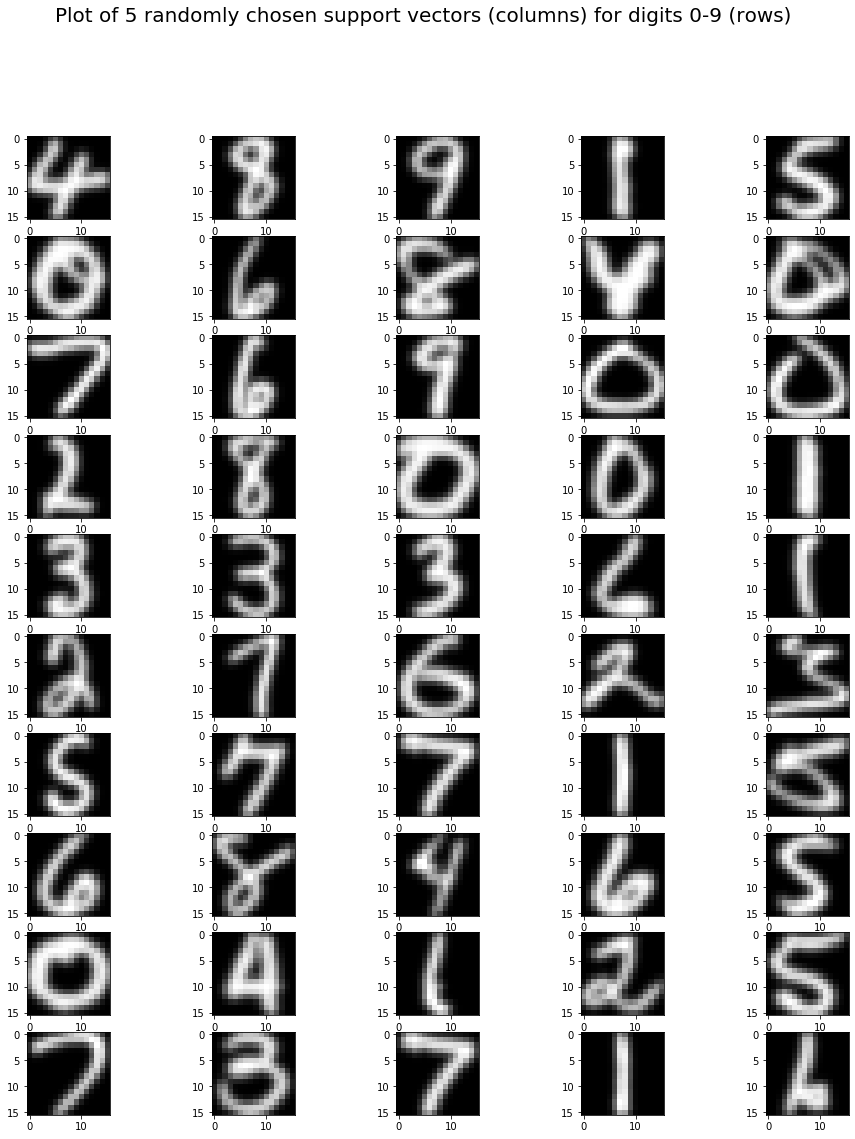

In [153]:
#6.3 Plot, for each digit, 5 randomly chosen Support Vectors from the two classes.

results = [{'kernel':'polynomial','kernelparameter':2,'C':1.75},
           {'kernel':'polynomial','kernelparameter':2,'C':1.25},
           {'kernel':'polynomial','kernelparameter':2,'C':1},
           {'kernel':'polynomial','kernelparameter':2,'C':[0.5]},
           {'kernel':'polynomial','kernelparameter':2,'C':[1.75]},
           {'kernel':'polynomial','kernelparameter':2,'C':[1.25]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[1.5]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[0.75]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[0.5]},
           {'kernel':'polynomial','kernelparameter':[2],'C':[0.5]},]


fig = plt.figure(figsize=(16, 18))
fig.suptitle('Plot of 5 randomly chosen support vectors (columns) for digits 0-9 (rows)',fontsize=20)
gs = fig.add_gridspec(10, 5)
for idx, params in enumerate(results):
    #print(params['kernel'])
    svm = svm_qp(kernel=params['kernel'],kernelparameter=params['kernelparameter'],C=params['C'])
    svm.fit(X_tr,y_tr.T[idx])
    #print(svm.X_sv)
    #print(svm.X_sv.shape)
    
    #select 5 random SVs
    X_pos = np.linspace(0,len(svm.X_sv)-1, len(svm.X_sv))
    random.Random(3).shuffle(X_pos)
    X = svm.X_sv[X_pos[:5].astype('int')]
    
    for idx2, sv in enumerate(X):
        f_ax1 = fig.add_subplot(gs[idx, idx2])
        plt.imshow(sv.reshape(16,16),cmap='gray')
    
    

    
    #plt.scatter(X,y)
    


In [158]:
def loss(ypred, ytrue):
    # compute cross entropy loss according to pg47 from guide.pdf
    loss = (-1/ytrue.shape[0])*np.sum(ytrue*np.log(ypred),axis=0)
    
    #loss = (-1 / ytrue.shape[0]) * tr.sum(ytrue * tr.log(ypred))
    
    return loss

In [167]:
def cv_nn(X, y, method, params, loss_function=loss, nfolds=10, nrepetitions=5):
    '''
    This function applies a cross validation procedure with a specified loss function and model parameters.

    Inputs:
    X = X training data (nxd)
    y = y training data (nxe)
    method = model
    params = the model parameters: the 'kernel', the 'kernelparameter' and 'regularisation' term.
    loss_function = the loss function to be used to calculate error.
    nfolds = number of equal sized folds
    nrepetitions = number of repetitions

    Outputs:
    method = the model object with the best parameters and cvloss.
    '''
    length, width = np.shape(X)
    # model = method
    method.cvloss = np.full((1,10),1000000)
    params_combinations = list(it.product(params['layers'], params['p'], params['lam'], params['lr']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(layers=parameter[0], p=parameter[1], lr=parameter[3], lam=parameter[2])
        e = np.zeros((1,10))
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int'))
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                print('loss\n',loss_function(ypred=y_pred,ytrue=y[part[j].astype('int')]))
                e = e + loss_function(ypred=y_pred,ytrue=y[part[j].astype('int')])
        e = e / (nfolds * nrepetitions)
        #sum_e = e.sum()
        
        #print('Loss:' + str(model.cvloss))
        if e.sum() < method.cvloss.sum():
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
            
    return method

In [168]:
# Fivefold Cross validation - NEURAL NETWORK


X = usps_data
y = data_labels
#replace neg label -1 with 0 for cross entropy loss func
y = np.where(y==-1,0,y)



#select 2005 random datapoints, so that we have equally sized folds
X_pos = np.linspace(0,len(X)-1, len(X))
random.Random(2).shuffle(X_pos)
X = X[X_pos[:2005].astype('int')]
y = y.T[X_pos[:2005].astype('int')]
print(X.shape)
print(y.shape)

#parameters to search from
params = { 'layers': [[256,20,200,10]], 'p': [0.05,0.1,0.15,0.2], 'lam': [0.0001,0.001,0.01,0.1], 'lr': [0.01,0.05,0.1] }

#try 'em out
#cross entropy loss for classification
cvnn = cv_nn(X, y, neural_network, params, loss_function=loss, nfolds=5, nrepetitions=1)
    
        
    

(2005, 256)
(2005, 10)














  0%|          | 0/48 [00:00<?, ?it/s]C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss
 [0.03185103 0.01496089 0.06056283 0.062932   0.09196355 0.0287006
 0.03952534 0.05888718 0.10747464 0.03594497]
loss
 [0.07386977 0.04495346 0.0151768  0.02325187 0.03937076 0.04106627
 0.03401813 0.04684902 0.09770253 0.01929036]
loss
 [0.03082931 0.04413256 0.07531743 0.0226636  0.04398263 0.08478875
 0.03184624 0.00118746 0.04138144 0.06373858]
loss
 [0.03373488 0.0011295  0.05280912 0.10311252 0.07428998 0.01616603
 0.00582262 0.02558485 0.0438174  0.04855714]
loss
 [0.02210126 0.00289759 0.03256915 0.10400632 0.11856399 0.06256197
 0.01234524 0.03983483 0.02496576 0.075817  ]














  2%|▏         | 1/48 [01:43<1:21:02, 103.46s/it]

loss
 [0.06353495 0.01783398 0.09487116 0.11172773 0.25291553 0.05961161
 0.03530106 0.03057523 0.14463562 0.10278948]
loss
 [0.01460892 0.04998359 0.07326489 0.0594903  0.02789165 0.26187718
 0.00087505 0.0342195  0.05896392 0.09926766]
loss
 [5.2979689e-02 3.7031667e-05 7.3412895e-02 1.7651573e-02 7.9797156e-02
 6.3667759e-02 5.2705668e-02 1.0959777e-02 1.7405940e-02 2.9217426e-02]
loss
 [0.04526369 0.02421319 0.09645983 0.08399953 0.19774029 0.08102331
 0.01006213 0.01278429 0.09834963 0.0247229 ]
loss
 [0.00987837 0.00502652 0.05632331 0.05672514 0.22853744 0.02509762
 0.04343318 0.01602053 0.03482553 0.06564593]














  4%|▍         | 2/48 [03:27<1:19:25, 103.59s/it]

loss
 [0.02574695 0.00476177 0.24534345 0.06105126 0.06909973 0.36633423
 0.03275235 0.02537123 0.04304338 0.14528364]
loss
 [0.03756325 0.00125102 0.11306953 0.05119142 0.16621509 0.09107718
 0.01460654 0.02609532 0.0664536  0.0766432 ]
loss
 [0.05343581 0.00208362 0.24445635 0.05492241 0.04120414 0.07668309
 0.00539632 0.04187869 0.09229941 0.19368084]
loss
 [0.07700769 0.04615455 0.07744451 0.10307997 0.21756728 0.03164928
 0.00858678 0.08759417 0.07294119 0.13318847]
loss
 [0.01898231 0.09346515 0.04857127 0.08293347 0.06239729 0.00730873
 0.06934471 0.09280828 0.01551121 0.00940049]














  6%|▋         | 3/48 [05:11<1:17:46, 103.69s/it]

loss
 [0.0522209  0.00725118 0.05961324 0.04983649 0.09481467 0.10647877
 0.03813883 0.04061898 0.07125337 0.03674562]
loss
 [0.01189389 0.02381816 0.10692938 0.02696646 0.06522311 0.09078357
 0.01178203 0.0576671  0.03412577 0.05690673]
loss
 [0.03711783 0.02436856 0.06813214 0.0645434  0.02561086 0.10487801
 0.03481537 0.03654448 0.06845374 0.03281519]
loss
 [0.03910476 0.05990435 0.06221698 0.03025405 0.01906395 0.05336412
 0.02708399 0.04025019 0.01211556 0.05585435]
loss
 [0.06405545 0.02042256 0.03507671 0.07607946 0.02950157 0.03553372
 0.01983733 0.01335679 0.05048607 0.02679178]














  8%|▊         | 4/48 [06:55<1:16:07, 103.80s/it]

loss
 [0.03742351 0.02599832 0.19041759 0.13277605 0.13237305 0.23996867
 0.05425432 0.0274138  0.06091801 0.23889022]
loss
 [0.00427299 0.07096891 0.18962245 0.0648342  0.02355542 0.15890145
 0.00219036 0.05280573 0.05190964 0.08400434]
loss
 [0.1332571  0.00663784 0.14727563 0.07764173 0.08723786 0.1263735
 0.0440991  0.01726683 0.05317365 0.02394629]
loss
 [0.01817761 0.03537638 0.11217965 0.0080344  0.05434437 0.02262181
 0.11574241 0.00771356 0.04109344 0.06594147]
loss
 [0.03611559 0.00026238 0.04925501 0.00524029 0.03412084 0.08018251
 0.05302804 0.08106966 0.0915673  0.02949027]














 10%|█         | 5/48 [08:39<1:14:22, 103.78s/it]

loss
 [0.04629815 0.04499457 0.10231764 0.07250885 0.08295164 0.08774485
 0.05919645 0.02207058 0.11438554 0.03748234]
loss
 [0.07653483 0.02953183 0.09941778 0.0588393  0.17010315 0.02833204
 0.01100769 0.01295117 0.10547905 0.01235593]
loss
 [0.01132745 0.00395998 0.07566074 0.0347188  0.1112372  0.11015876
 0.01078664 0.03203854 0.14042835 0.03982328]
loss
 [0.0207283  0.03733118 0.09802014 0.04095573 0.07805314 0.08546742
 0.00225993 0.03174051 0.0593692  0.03307339]
loss
 [0.10029539 0.02931037 0.21993734 0.02831721 0.00361734 0.04062446
 0.02778278 0.05947628 0.08926219 0.02053159]














 12%|█▎        | 6/48 [10:23<1:12:45, 103.94s/it]

loss
 [0.04025231 0.0559534  0.06474935 0.05560747 0.09919761 0.0549022
 0.01515482 0.04775702 0.10443168 0.07164321]
loss
 [0.13823669 0.02966483 0.03916155 0.01303251 0.08381027 0.11315215
 0.02520785 0.09790584 0.0701912  0.02449542]
loss
 [0.04763035 0.01451867 0.13828462 0.06851839 0.08013082 0.08583091
 0.01664902 0.03245476 0.03406104 0.00903921]
loss
 [0.02297167 0.0020516  0.09867893 0.04758438 0.06792906 0.05868189
 0.0205387  0.01920854 0.03293948 0.0357721 ]
loss
 [0.0167549  0.03949985 0.02065925 0.04985317 0.01573821 0.08139263
 0.02370934 0.03598118 0.03772778 0.07566236]














 15%|█▍        | 7/48 [12:07<1:11:08, 104.11s/it]

loss
 [0.04627058 0.01901235 0.11323704 0.0817705  0.03745064 0.04758037
 0.03594393 0.04388031 0.03581483 0.06841724]
loss
 [0.05572079 0.00945143 0.09145304 0.06792715 0.01994492 0.06545885
 0.01810356 0.05284586 0.04639515 0.01561943]
loss
 [0.04506565 0.02717719 0.05857845 0.04253799 0.04288437 0.01666403
 0.03629335 0.02913187 0.0580673  0.05733666]
loss
 [0.03960069 0.01607031 0.08352198 0.02725733 0.0419116  0.08739395
 0.00215151 0.04011798 0.06220863 0.02984616]
loss
 [0.04920316 0.00529944 0.03690093 0.09692314 0.06933891 0.07108159
 0.06712922 0.00976992 0.04621099 0.05333062]














 17%|█▋        | 8/48 [13:51<1:09:19, 103.99s/it]

loss
 [0.01753715 0.00245742 0.03899377 0.04952585 0.11186212 0.04808792
 0.03031043 0.03127155 0.11123344 0.01833053]
loss
 [0.02303642 0.00384648 0.19673695 0.05240311 0.03444137 0.04469879
 0.03113498 0.02866567 0.1293647  0.04138864]
loss
 [0.04719946 0.03126171 0.04775931 0.01692444 0.04669284 0.1621716
 0.01868486 0.05330191 0.05473028 0.08934618]
loss
 [0.07652191 0.00780867 0.09979545 0.06518634 0.07509188 0.05195623
 0.02366896 0.03243383 0.05224188 0.02794451]
loss
 [0.01870939 0.05297207 0.04237644 0.07998518 0.08800379 0.06596433
 0.02337129 0.03759218 0.02852366 0.02560775]














 19%|█▉        | 9/48 [15:35<1:07:30, 103.85s/it]

loss
 [0.04457332 0.07377881 0.20367967 0.10279718 0.13467418 0.19088048
 0.08417975 0.09984736 0.06447461 0.06892695]
loss
 [0.05874743 0.08236443 0.10843578 0.10852046 0.05815852 0.11723003
 0.10710184 0.08127823 0.13957627 0.07858818]
loss
 [0.09691268 0.03125193 0.07203262 0.07936069 0.09272405 0.09320419
 0.06692773 0.06077324 0.08818075 0.07379619]
loss
 [0.06902021 0.02846351 0.08057369 0.0610204  0.12581113 0.15616432
 0.03848974 0.07194693 0.08228624 0.08853148]
loss
 [0.09244186 0.03038916 0.14079778 0.110351   0.06761269 0.07837187
 0.05072918 0.06596143 0.07562567 0.08599833]














 21%|██        | 10/48 [17:18<1:05:46, 103.85s/it]

loss
 [0.09231466 0.07390863 0.05564773 0.08514517 0.10613097 0.07486742
 0.03693634 0.08521713 0.09903956 0.04928738]
loss
 [0.06973511 0.04467925 0.0753117  0.10108415 0.08286433 0.09026538
 0.07962829 0.03233348 0.08922426 0.12701388]
loss
 [0.0696665  0.0338008  0.09601998 0.05751797 0.09138761 0.06627543
 0.04889598 0.10041226 0.0953438  0.06460214]
loss
 [0.06201877 0.04180473 0.16595812 0.10791292 0.0700708  0.0788496
 0.0729532  0.07558833 0.0716672  0.09558465]
loss
 [0.03522561 0.03689221 0.12519814 0.10475304 0.07310652 0.1300837
 0.04431663 0.04084382 0.12665266 0.0762165 ]














 23%|██▎       | 11/48 [19:02<1:03:54, 103.65s/it]

loss
 [0.0452312  0.07574863 0.07658977 0.06602578 0.09099124 0.12769482
 0.11895957 0.05191055 0.09552025 0.06903667]
loss
 [0.06626758 0.06643628 0.11404195 0.08992045 0.1084362  0.11245235
 0.05429898 0.03982935 0.07257082 0.10000069]
loss
 [0.09248094 0.0140315  0.09396202 0.05105152 0.06963807 0.0694747
 0.05652739 0.2229339  0.18590346 0.14217411]
loss
 [0.08706351 0.02530287 0.08558658 0.10187893 0.10179371 0.06860991
 0.07408235 0.09522071 0.098722   0.0967634 ]
loss
 [0.07255434 0.05007686 0.09284798 0.08741736 0.11414607 0.11468808
 0.04724154 0.03257152 0.2135963  0.11166477]














 25%|██▌       | 12/48 [20:45<1:02:06, 103.51s/it]

loss
 [0.02620172 0.0131874  0.11476303 0.0296084  0.03822416 0.09948272
 0.08916456 0.04272142 0.09514005 0.05674507]
loss
 [0.04281867 0.04976983 0.12304403 0.05511345 0.03382935 0.09348761
 0.00779546 0.03393976 0.07300567 0.02528599]
loss
 [0.02092018 0.02862814 0.08854292 0.03518593 0.09740493 0.07468841
 0.00222948 0.03500535 0.06574345 0.0262589 ]
loss
 [0.06508917 0.00740819 0.03490627 0.04115963 0.05673748 0.0369782
 0.01156281 0.04257336 0.00806029 0.01860342]
loss
 [0.02015457 0.013135   0.04154255 0.03151686 0.06999709 0.05340732
 0.03442012 0.06244202 0.05665203 0.04132519]














 27%|██▋       | 13/48 [22:29<1:00:29, 103.69s/it]

loss
 [0.07005703 0.02501359 0.11314659 0.07795224 0.09086729 0.04684162
 0.0173296  0.0163336  0.1841141  0.0453699 ]
loss
 [0.04810386 0.0422764  0.0372439  0.05799294 0.07633595 0.14947475
 0.09255788 0.10180336 0.07653745 0.04154318]
loss
 [0.01463514 0.09348618 0.24240597 0.10269883 0.02434379 0.12082247
 0.03835644 0.03077192 0.03624225 0.04387508]
loss
 [0.05972709 0.01644465 0.09770946 0.03342891 0.07483747 0.08316609
 0.02090805 0.04477978 0.10668097 0.01889816]
loss
 [0.04127781 0.00546697 0.06580495 0.06348488 0.10268184 0.04532818
 0.03126014 0.04252617 0.03565963 0.08455801]














 29%|██▉       | 14/48 [24:13<58:48, 103.79s/it]  

loss
 [0.10683431 0.03814922 0.09156874 0.09852135 0.08036068 0.16565236
 0.05148669 0.05070795 0.0297927  0.08360193]
loss
 [0.08028858 0.01287629 0.05286745 0.04685859 0.07536048 0.07184805
 0.00942757 0.07107544 0.22531419 0.02713912]
loss
 [0.04731368 0.02028403 0.03349958 0.03339535 0.04255075 0.0743823
 0.0033232  0.04056229 0.04980104 0.02608633]
loss
 [0.02531736 0.03494868 0.29534107 0.05087163 0.09972356 0.02390513
 0.08501492 0.0060076  0.01447742 0.04474188]
loss
 [0.06685091 0.04306107 0.03549791 0.05489988 0.14069027 0.03167973
 0.00084941 0.08028012 0.08300489 0.04648391]














 31%|███▏      | 15/48 [25:57<57:08, 103.90s/it]

loss
 [0.09416841 0.02448369 0.16118798 0.08380891 0.06867072 0.02804148
 0.04172128 0.04728458 0.0516795  0.04877564]
loss
 [0.01786103 0.02357453 0.07900568 0.05148062 0.10601097 0.04954365
 0.03159258 0.02711704 0.07014252 0.0431543 ]
loss
 [0.09189834 0.03123919 0.03590972 0.0378955  0.05257544 0.07714775
 0.02919746 0.00801729 0.03664184 0.04209846]
loss
 [0.05439859 0.00680546 0.07546427 0.0441667  0.04757308 0.04102167
 0.02288156 0.02101377 0.06326935 0.04027624]
loss
 [0.00710137 0.01932385 0.0298237  0.05103892 0.06378121 0.04995575
 0.0408431  0.02648606 0.03168482 0.01770825]














 33%|███▎      | 16/48 [27:41<55:25, 103.94s/it]

loss
 [0.0021354  0.06511047 0.06316041 0.02017578 0.05139722 0.14709648
 0.0337717  0.02752686 0.0595253  0.08395328]
loss
 [0.01967856 0.00544519 0.04114141 0.03226831 0.02294846 0.09622888
 0.05925567 0.07885254 0.04962951 0.03262177]
loss
 [0.10946964 0.03607256 0.1007922  0.08642239 0.01175973 0.0941992
 0.06060369 0.01710287 0.10305763 0.044436  ]
loss
 [0.09534299 0.0336656  0.06719854 0.11085438 0.09693934 0.12348202
 0.00624551 0.03335303 0.02720411 0.02652095]
loss
 [0.08014114 0.00449483 0.07110336 0.03213429 0.08081506 0.08042597
 0.01444231 0.00058766 0.0151222  0.04816385]














 35%|███▌      | 17/48 [29:29<54:20, 105.19s/it]

loss
 [0.08377565 0.02541397 0.12623172 0.11026793 0.1253881  0.04227087
 0.04142445 0.11304841 0.11628451 0.03834432]
loss
 [0.03722914 0.00321652 0.07916749 0.05798906 0.07437476 0.04155596
 0.06068897 0.01833547 0.05238029 0.07436553]
loss
 [0.00129317 0.03370339 0.07607414 0.00446959 0.09284513 0.10841128
 0.0081573  0.01386599 0.03203323 0.07715496]
loss
 [0.18666963 0.00767809 0.06842605 0.05038422 0.0305943  0.12182945
 0.03042719 0.03583566 0.02107825 0.01042126]
loss
 [0.12538773 0.02876133 0.05451596 0.08189575 0.0363114  0.08444381
 0.01821498 0.0399552  0.14946917 0.01252717]














 38%|███▊      | 18/48 [31:17<52:57, 105.92s/it]

loss
 [0.03997004 0.02603671 0.06129688 0.04129959 0.09503765 0.06700557
 0.0285991  0.10188479 0.07208903 0.03763519]
loss
 [0.04133163 0.01906779 0.04314306 0.04883133 0.08806131 0.07899256
 0.05005688 0.05507353 0.09284052 0.03437887]
loss
 [0.05560967 0.02306576 0.07778781 0.01940938 0.06350907 0.02746539
 0.02838363 0.04807624 0.06649863 0.04026658]
loss
 [0.00560887 0.01705386 0.08754933 0.06555106 0.06481849 0.03908211
 0.00822402 0.00860068 0.03984864 0.06441438]
loss
 [0.03183511 0.00984227 0.08674102 0.02899643 0.03789556 0.06168219
 0.04413886 0.0215282  0.06560895 0.03470902]














 40%|███▉      | 19/48 [33:10<52:17, 108.20s/it]

loss
 [0.03764674 0.00301869 0.056693   0.06143478 0.05344032 0.08827411
 0.05188169 0.07461441 0.10983381 0.03302241]
loss
 [0.02477026 0.02373894 0.04936929 0.05086775 0.0515311  0.09523892
 0.036384   0.03592828 0.06837893 0.02736897]
loss
 [0.03245687 0.01724569 0.03714508 0.05169461 0.08459737 0.02371855
 0.02714038 0.03053068 0.04581314 0.0298526 ]
loss
 [0.04085727 0.0204936  0.02896161 0.02246859 0.05216403 0.13355465
 0.01117532 0.0085963  0.05714797 0.02228531]
loss
 [0.02445403 0.04506311 0.06659888 0.05324132 0.06754132 0.07558013
 0.00704889 0.04710881 0.05293604 0.03055555]














 42%|████▏     | 20/48 [35:04<51:19, 109.97s/it]

loss
 [0.06454149 0.0168972  0.14765598 0.04003073 0.04086335 0.14964448
 0.01890592 0.04555578 0.08729456 0.10284488]
loss
 [0.02104859 0.04665871 0.0469266  0.0199329  0.06566304 0.07951227
 0.03382718 0.04755377 0.11515567 0.02781985]
loss
 [0.05435967 0.00227841 0.04524395 0.05793326 0.04930091 0.07306377
 0.0238483  0.05735395 0.06269258 0.03893062]
loss
 [0.05745166 0.00361983 0.02352427 0.04970137 0.08996409 0.06923033
 0.0517603  0.01786554 0.02076908 0.03159383]
loss
 [0.02133286 0.03780963 0.19101974 0.11193063 0.07821273 0.08148082
 0.01476739 0.04314357 0.05249221 0.0244071 ]














 44%|████▍     | 21/48 [36:52<49:13, 109.37s/it]

loss
 [0.05659121 0.07774249 0.19413686 0.10893633 0.09611297 0.09210225
 0.07651071 0.10257451 0.12685855 0.10473787]
loss
 [0.05654322 0.05809027 0.1318835  0.11632719 0.09510092 0.11331068
 0.07920993 0.06581834 0.08393564 0.14647914]
loss
 [0.09574851 0.03731228 0.14759284 0.11302147 0.11918729 0.17991313
 0.07070112 0.0668527  0.12030777 0.06731433]
loss
 [0.05368361 0.02514285 0.17806551 0.09906303 0.08734971 0.14376606
 0.06295185 0.17288056 0.13565753 0.09101076]
loss
 [0.0623928  0.04150921 0.10984746 0.07000128 0.07783251 0.217846
 0.04368264 0.06392788 0.11743231 0.10449557]














 46%|████▌     | 22/48 [38:36<46:38, 107.62s/it]

loss
 [0.05530238 0.05422798 0.09140434 0.06618776 0.06232023 0.09047794
 0.13694859 0.03450146 0.13320424 0.14978126]
loss
 [0.04751423 0.04845292 0.08836335 0.06114246 0.12769139 0.13407011
 0.0575556  0.08964822 0.10890845 0.08027549]
loss
 [0.14276771 0.05614184 0.13597594 0.10492302 0.06875294 0.06575779
 0.05108836 0.06382632 0.15891106 0.05826355]
loss
 [0.03939627 0.03067426 0.13395615 0.08183783 0.12164175 0.11335991
 0.08029228 0.05114598 0.15152219 0.09218644]
loss
 [0.06637147 0.05772856 0.08328294 0.10554197 0.07660463 0.14355531
 0.05983603 0.18286777 0.13357675 0.08283776]














 48%|████▊     | 23/48 [40:20<44:19, 106.39s/it]

loss
 [0.05922942 0.03804529 0.15468013 0.08809181 0.13731466 0.08940955
 0.10111789 0.09710609 0.10748555 0.12889914]
loss
 [0.05657268 0.07122247 0.13584048 0.18196523 0.07820316 0.10787231
 0.12783729 0.16293655 0.06647545 0.05987739]
loss
 [0.0633992  0.05353608 0.05638847 0.12331606 0.10023783 0.09715234
 0.03417464 0.08779866 0.21623543 0.08601774]
loss
 [0.066232   0.10691596 0.14483458 0.08492992 0.04930647 0.12304072
 0.08114894 0.05551987 0.17957865 0.09868322]
loss
 [0.03135839 0.05524735 0.10021964 0.06228013 0.13734333 0.15097846
 0.05772128 0.07964292 0.11683115 0.09119387]














 50%|█████     | 24/48 [42:03<42:14, 105.58s/it]

loss
 [0.02010971 0.02421928 0.10755353 0.0284865  0.04557185 0.0820475
 0.02872749 0.04318677 0.11780644 0.07945971]
loss
 [0.03464177 0.04415462 0.0839885  0.0482701  0.08095883 0.07805711
 0.01798922 0.01243497 0.04491598 0.03780763]
loss
 [0.09561579 0.08380347 0.03501663 0.05359082 0.01634849 0.06867632
 0.00566779 0.02806625 0.0462964  0.03172619]
loss
 [0.01500783 0.00038444 0.06311164 0.03233618 0.03486883 0.05450824
 0.03630645 0.05786917 0.04813307 0.02563152]
loss
 [0.0231423  0.00327184 0.0250618  0.04760917 0.08537591 0.0402322
 0.03434961 0.02033016 0.05560862 0.01299172]














 52%|█████▏    | 25/48 [43:47<40:18, 105.16s/it]

loss
 [0.07526901 0.00687864 0.0945566  0.05652204 0.05768153 0.17237912
 0.05505603 0.00699391 0.06242088 0.05379742]
loss
 [0.02055864 0.04343771 0.06753734 0.08901366 0.03978677 0.06898019
 0.02440758 0.03063855 0.12067236 0.06119686]
loss
 [0.09949058 0.09702914 0.11601094 0.11762027 0.01443525 0.09315985
 0.00928634 0.047972   0.04723126 0.03227451]
loss
 [0.03246965 0.05692858 0.21450204 0.04610319 0.06700952 0.0580642
 0.03130935 0.02922    0.00966815 0.07570574]
loss
 [1.2915629e-01 8.1097576e-05 5.7677563e-02 8.1884980e-02 1.2020313e-01
 1.3102217e-01 2.8277752e-03 2.7275812e-02 8.3509274e-02 1.3837249e-02]














 54%|█████▍    | 26/48 [45:32<38:31, 105.07s/it]

loss
 [0.06451412 0.07097504 0.09327439 0.03488149 0.05521668 0.22148627
 0.01529425 0.05889515 0.1507033  0.08238437]
loss
 [0.01966828 0.05073611 0.10219875 0.02875341 0.09848194 0.180578
 0.08676048 0.15573017 0.12877773 0.00225349]
loss
 [0.05591191 0.05875669 0.07505909 0.06362872 0.03296158 0.14622927
 0.00681019 0.07448749 0.06870583 0.02322552]
loss
 [nan nan nan nan nan nan nan nan nan nan]
loss
 [nan nan nan nan nan nan nan nan nan nan]














 56%|█████▋    | 27/48 [47:18<36:49, 105.20s/it]

loss
 [0.02379926 0.00894833 0.13794106 0.06609099 0.07083634 0.06683964
 0.06794672 0.06200948 0.13633463 0.04385055]
loss
 [0.05603686 0.02613895 0.01668813 0.03329487 0.0784021  0.05374366
 0.02113466 0.04773051 0.06697203 0.06019081]
loss
 [0.05782356 0.01846856 0.05909137 0.06797646 0.01652376 0.06606317
 0.03917037 0.00494868 0.08988986 0.0466175 ]
loss
 [0.0230724  0.02832381 0.03922514 0.07686541 0.04023703 0.01454221
 0.02023076 0.03038007 0.03783888 0.04629944]
loss
 [0.01278424 0.01328752 0.03896665 0.04857123 0.03162445 0.06527033
 0.03731474 0.04639198 0.05125277 0.00790569]














 58%|█████▊    | 28/48 [49:02<34:58, 104.92s/it]

loss
 [0.05391568 0.01948849 0.19439124 0.07743488 0.15626384 0.0974644
 0.00835429 0.005203   0.08806259 0.01575459]
loss
 [0.02196134 0.08493214 0.10739569 0.0362521  0.09316959 0.08465531
 0.0144351  0.1477945  0.1070284  0.05114888]
loss
 [0.04793668 0.01397637 0.06464782 0.12985171 0.02268477 0.12640738
 0.01092386 0.05647389 0.04803485 0.08690598]
loss
 [0.01868763 0.02332995 0.00592324 0.0563592  0.07081021 0.05665295
 0.0369815  0.0243179  0.11758126 0.02191225]
loss
 [0.03543426 0.01048552 0.06916167 0.05523245 0.08237755 0.03654011
 0.01706686 0.01009676 0.06312598 0.09150749]














 60%|██████    | 29/48 [50:46<33:09, 104.68s/it]

loss
 [0.08426306 0.00900027 0.03195132 0.06489202 0.16151012 0.17097507
 0.04453425 0.00514851 0.0454481  0.0719877 ]
loss
 [0.04580059 0.03306789 0.09575359 0.07344265 0.18067667 0.11911036
 0.04033313 0.05638647 0.1052282  0.01690414]
loss
 [0.11177292 0.03609702 0.03157945 0.0687499  0.02788019 0.039547
 0.02070483 0.02307012 0.0692416  0.05789084]
loss
 [0.03544554 0.03780385 0.19489889 0.06939556 0.03453629 0.06680744
 0.04565229 0.04539661 0.07350479 0.01548835]
loss
 [0.01162451 0.02073967 0.06168962 0.0725185  0.0043688  0.03972457
 0.02201606 0.0298496  0.0909364  0.04701427]














 62%|██████▎   | 30/48 [52:31<31:23, 104.63s/it]

loss
 [0.07551546 0.01280665 0.13745916 0.02733422 0.07423879 0.05521486
 0.085953   0.11507645 0.10814697 0.05836662]
loss
 [0.03966438 0.02399625 0.04248234 0.04534778 0.09485229 0.07435326
 0.02412691 0.04929696 0.06078821 0.04015622]
loss
 [0.04556139 0.0381537  0.03058718 0.05841897 0.06513895 0.09497645
 0.02913423 0.02326545 0.09031093 0.04460349]
loss
 [0.02632566 0.04561997 0.04042191 0.03792185 0.05153972 0.04752069
 0.0085657  0.04621069 0.05053282 0.06729504]
loss
 [0.0137085  0.02217071 0.05829796 0.07435194 0.03974603 0.03328183
 0.01155492 0.03352775 0.06549632 0.01965787]














 65%|██████▍   | 31/48 [54:15<29:36, 104.50s/it]

loss
 [0.06461793 0.02500657 0.04571299 0.10931765 0.09054583 0.13162088
 0.02201788 0.07752506 0.09717325 0.05036867]
loss
 [0.00176944 0.00470968 0.08466262 0.03658568 0.11569966 0.07236137
 0.02635498 0.02119189 0.06935982 0.06510074]
loss
 [0.05912794 0.01662894 0.04950527 0.07256781 0.03643512 0.03718318
 0.02291397 0.01260386 0.10946888 0.03802281]
loss
 [0.05330333 0.00946332 0.10006428 0.08914991 0.09147345 0.09988762
 0.02282478 0.00490389 0.07048362 0.05624297]
loss
 [0.0635177  0.00263432 0.1141422  0.06190447 0.03160324 0.05440421
 0.02689373 0.04135244 0.02891478 0.01644437]














 67%|██████▋   | 32/48 [55:59<27:51, 104.44s/it]

loss
 [0.09177246 0.00243972 0.03068055 0.03122751 0.05276276 0.12345056
 0.02344548 0.10688675 0.02526682 0.0286478 ]
loss
 [0.03311313 0.01684325 0.17647935 0.0723447  0.11115947 0.13763097
 0.01819583 0.03260097 0.05795364 0.03153189]
loss
 [0.00842475 0.0115013  0.07666457 0.05122754 0.0363355  0.04727819
 0.04048317 0.02659953 0.06564457 0.03290125]
loss
 [0.04229894 0.02188772 0.03891526 0.05067977 0.06211718 0.06184656
 0.0406367  0.0476185  0.10083108 0.03436311]
loss
 [0.03133385 0.02214227 0.04295376 0.04152664 0.08682532 0.08537976
 0.04920186 0.02594138 0.03779502 0.07319641]














 69%|██████▉   | 33/48 [57:43<26:05, 104.37s/it]

loss
 [0.06956298 0.06487366 0.15083769 0.11309443 0.15154007 0.10874831
 0.06579936 0.11577529 0.20622636 0.12364875]
loss
 [0.04918654 0.04064689 0.20906202 0.08702523 0.18952143 0.15127814
 0.11207159 0.08710857 0.17799631 0.1520355 ]
loss
 [0.05732801 0.04402846 0.12452217 0.11650207 0.08641329 0.14943686
 0.07584912 0.11100953 0.19538534 0.11571302]
loss
 [0.11427744 0.05067742 0.10332289 0.07370868 0.18354869 0.12722585
 0.0418741  0.07318461 0.14535086 0.09627482]
loss
 [0.10435952 0.04964614 0.16021065 0.09380963 0.12330657 0.09418173
 0.06101403 0.09261657 0.12620266 0.08961166]














 71%|███████   | 34/48 [59:27<24:17, 104.13s/it]

loss
 [0.05257716 0.05764375 0.14260489 0.1202354  0.11088225 0.09029394
 0.07864919 0.10356836 0.10387687 0.13720424]
loss
 [0.07240862 0.05962496 0.09144711 0.08798956 0.12514986 0.13789015
 0.04482162 0.07772001 0.15502097 0.05841854]
loss
 [0.06614254 0.05770191 0.15635939 0.08001354 0.08865682 0.12530594
 0.08450399 0.13763562 0.11948574 0.07666679]
loss
 [0.07429519 0.03771407 0.14353877 0.1184992  0.08940301 0.12326957
 0.05910916 0.09465417 0.13209163 0.12298457]
loss
 [0.13038522 0.02753006 0.11050048 0.07344057 0.11546243 0.14954197
 0.03952412 0.10864357 0.2034105  0.08650733]














 73%|███████▎  | 35/48 [1:01:11<22:32, 104.02s/it]

loss
 [0.04411404 0.05342463 0.190825   0.06933594 0.09721377 0.14115727
 0.10360163 0.06198511 0.17437048 0.08891636]
loss
 [0.04383632 0.04173975 0.14745578 0.09785753 0.07488009 0.08934109
 0.07497508 0.1404348  0.21314624 0.07278354]
loss
 [0.06748456 0.04806856 0.13476186 0.1384764  0.08246547 0.09173213
 0.0414478  0.08091151 0.11587934 0.1369411 ]
loss
 [0.08954502 0.03511694 0.17617245 0.17097959 0.158534   0.04163853
 0.06169545 0.1151638  0.21170586 0.09498546]
loss
 [0.10628894 0.07047971 0.08991442 0.23146242 0.13530871 0.10559124
 0.09915718 0.09667793 0.07821068 0.09880287]














 75%|███████▌  | 36/48 [1:02:54<20:46, 103.91s/it]

loss
 [0.01937013 0.01780175 0.0627296  0.05109799 0.12912735 0.05472272
 0.039941   0.07139779 0.144647   0.11661924]
loss
 [0.04336936 0.00142351 0.08665073 0.0553423  0.05154989 0.04706473
 0.02412793 0.05810903 0.01964424 0.10432715]
loss
 [0.06477004 0.02203709 0.03524078 0.02396158 0.06585295 0.10381671
 0.0406973  0.01193358 0.08796106 0.03580241]
loss
 [0.02356244 0.0307869  0.04968968 0.10055116 0.06022225 0.0362115
 0.03658536 0.02841512 0.08608096 0.01317775]
loss
 [0.01776367 0.02505994 0.01588778 0.02827075 0.03494323 0.04992156
 0.00966913 0.06352586 0.06554479 0.03310774]














 77%|███████▋  | 37/48 [1:04:39<19:04, 104.00s/it]

loss
 [0.03863716 0.06964041 0.03803255 0.12393828 0.08608368 0.08231401
 0.03716109 0.08143392 0.03941297 0.04544298]
loss
 [0.07665645 0.01462734 0.0410146  0.06600206 0.11865171 0.1076005
 0.01091548 0.01199297 0.06116648 0.01345338]
loss
 [0.00265255 0.0200201  0.10698956 0.10850857 0.05205958 0.14197297
 0.02324936 0.06037019 0.04504045 0.04301897]
loss
 [0.04845008 0.0236381  0.1721618  0.03918588 0.04592579 0.11830886
 0.02697906 0.03227082 0.08337963 0.05345061]
loss
 [0.09912798 0.0338544  0.13859294 0.03822995 0.0293938  0.0939225
 0.04524103 0.01493864 0.04645387 0.00179829]














 79%|███████▉  | 38/48 [1:06:30<17:42, 106.30s/it]

loss
 [0.08138543 0.05528653 0.18298852 0.04951015 0.0899393  0.07083429
 0.07321727 0.09601385 0.15978238 0.04887061]
loss
 [0.00955267 0.04168154 0.10710878 0.01354975 0.10501055 0.13323604
 0.0372437  0.0354584  0.09160306 0.15341674]
loss
 [nan nan nan nan nan nan nan nan nan nan]
loss
 [nan nan nan nan nan nan nan nan nan nan]
loss
 [nan nan nan nan nan nan nan nan nan nan]














 81%|████████▏ | 39/48 [1:08:20<16:05, 107.31s/it]

loss
 [0.03807833 0.04087199 0.12630302 0.0777095  0.07390486 0.06805754
 0.04117114 0.05752925 0.05831755 0.08954232]
loss
 [0.04780409 0.00749893 0.09359207 0.04360927 0.08319786 0.06654674
 0.03994928 0.06808756 0.05497017 0.042232  ]
loss
 [0.02981509 0.02528558 0.13479301 0.02687044 0.07688553 0.09247135
 0.0188766  0.03491771 0.03258626 0.03234927]
loss
 [0.01131566 0.01594508 0.05259249 0.03147841 0.04472647 0.10415214
 0.04567551 0.01527751 0.05026254 0.05716474]
loss
 [0.04128465 0.06989604 0.01706504 0.05618926 0.02372506 0.02976951
 0.00766663 0.04451894 0.04520991 0.02787348]














 83%|████████▎ | 40/48 [1:10:08<14:19, 107.48s/it]

loss
 [0.05861094 0.03033203 0.08434368 0.0619393  0.1124856  0.12219083
 0.02371596 0.02909985 0.09311122 0.03527795]
loss
 [0.05153254 0.02230667 0.06467369 0.09136102 0.02713025 0.07719623
 0.0253966  0.00174918 0.08300003 0.19212745]
loss
 [0.04360982 0.07159664 0.07009655 0.08407152 0.08374479 0.11063177
 0.03626757 0.06450541 0.03064709 0.01679389]
loss
 [4.4009797e-02 2.0538402e-05 6.9195949e-02 1.2516792e-01 7.3387288e-02
 3.7932780e-02 4.7617978e-03 4.5619354e-02 2.7008018e-02 9.0509588e-03]
loss
 [0.08700817 0.00620302 0.04910154 0.03562407 0.06580411 0.01300772
 0.04707364 0.0238592  0.04734433 0.03486986]














 85%|████████▌ | 41/48 [1:11:57<12:36, 108.08s/it]

loss
 [0.01982662 0.04147729 0.16448952 0.03747718 0.08682336 0.0750613
 0.00623533 0.08792526 0.16540119 0.04231571]
loss
 [0.02305871 0.0705008  0.13606575 0.0701051  0.01719776 0.04433888
 0.02820199 0.15352257 0.11777474 0.07615807]
loss
 [0.03499107 0.01694365 0.15463668 0.03932249 0.09125694 0.07554734
 0.01443461 0.06668819 0.04931618 0.02245991]
loss
 [nan nan nan nan nan nan nan nan nan nan]
loss
 [nan nan nan nan nan nan nan nan nan nan]














 88%|████████▊ | 42/48 [1:13:48<10:52, 108.75s/it]

loss
 [0.08899304 0.0257233  0.09491719 0.09552617 0.05272887 0.09427905
 0.02424511 0.06111766 0.10489935 0.04231071]
loss
 [0.04164527 0.00537306 0.04884599 0.05237146 0.06530129 0.11630065
 0.02586074 0.02592933 0.03528129 0.14063908]
loss
 [0.0604687  0.02397775 0.05469163 0.10615355 0.04136461 0.07378193
 0.03325585 0.06141862 0.07176723 0.05802695]
loss
 [0.03060526 0.01808526 0.0487796  0.02289901 0.06001049 0.07196643
 0.05326763 0.02813136 0.0521869  0.02783247]
loss
 [0.02190416 0.00982912 0.03273294 0.03000232 0.06102362 0.04304959
 0.01556773 0.05003841 0.07303501 0.04297333]














 90%|████████▉ | 43/48 [1:15:39<09:07, 109.41s/it]

loss
 [0.08775034 0.00216746 0.08035947 0.06839939 0.07387312 0.03750706
 0.05477774 0.00883437 0.04222766 0.0688199 ]
loss
 [0.02092286 0.04408595 0.07830294 0.03815336 0.1558366  0.11472213
 0.01142338 0.02272924 0.04811282 0.08833347]
loss
 [0.03433304 0.02658461 0.03584776 0.05153422 0.0781668  0.0720216
 0.00538336 0.06423894 0.08042792 0.04381429]
loss
 [0.07649818 0.01800069 0.08884997 0.0774828  0.04037662 0.07104465
 0.01998749 0.01332482 0.09609187 0.01332743]
loss
 [0.04071698 0.02792562 0.04766474 0.03083101 0.04331224 0.06608517
 0.03441672 0.03870462 0.06652553 0.02983713]














 92%|█████████▏| 44/48 [1:17:36<07:26, 111.73s/it]

loss
 [0.0603652  0.00076571 0.04840524 0.04048035 0.05342285 0.06415717
 0.01939527 0.01152366 0.1141056  0.03372245]
loss
 [0.03547082 0.01347104 0.13239507 0.02728121 0.03457282 0.05184716
 0.03366992 0.03877397 0.07126355 0.04338831]
loss
 [0.04666161 0.01182968 0.0738569  0.08977684 0.09551389 0.03266678
 0.02740907 0.00949135 0.05102829 0.06190119]
loss
 [0.06680665 0.01073113 0.10219999 0.09791582 0.11167433 0.02335467
 0.02103146 0.04598841 0.04065085 0.04691198]
loss
 [0.02534022 0.03168868 0.1346686  0.04409724 0.03068131 0.07575894
 0.05127391 0.03344192 0.13970329 0.06098349]














 94%|█████████▍| 45/48 [1:19:30<05:37, 112.59s/it]

loss
 [0.09630591 0.06897913 0.16862673 0.24115615 0.14806399 0.13059738
 0.20833047 0.17415701 0.1350501  0.16162433]
loss
 [0.10116641 0.06593151 0.17542711 0.1635017  0.12512423 0.13643518
 0.09043371 0.10235099 0.2152199  0.14152136]
loss
 [0.08065007 0.06491961 0.25627968 0.2459606  0.13984096 0.15493995
 0.03978525 0.08617977 0.1916171  0.09180833]
loss
 [0.1039047  0.06731207 0.22222196 0.07989612 0.14633437 0.12902637
 0.09005816 0.07895729 0.16571936 0.09865318]
loss
 [0.08027438 0.07062072 0.15032516 0.05049688 0.12899093 0.18511419
 0.11922825 0.08334945 0.1448913  0.15082178]














 96%|█████████▌| 46/48 [1:21:25<03:46, 113.16s/it]

loss
 [0.06584718 0.04560739 0.21136707 0.08587158 0.12974383 0.17586818
 0.1009731  0.100834   0.16212852 0.11846191]
loss
 [0.04781704 0.10601786 0.20282792 0.09669946 0.0998558  0.15888193
 0.12199589 0.10172068 0.20340596 0.0954808 ]
loss
 [0.11999682 0.049439   0.10759655 0.11279822 0.10524305 0.0973599
 0.12396915 0.14218695 0.16118908 0.11026385]
loss
 [0.09278587 0.07147074 0.17634836 0.14761348 0.07078663 0.14384848
 0.0605957  0.10392983 0.13181737 0.07359546]
loss
 [0.08575776 0.0443848  0.14235704 0.12469205 0.13705829 0.14054821
 0.05330917 0.10177952 0.15744352 0.10818546]














 98%|█████████▊| 47/48 [1:23:17<01:52, 112.86s/it]

loss
 [0.06114763 0.07575266 0.2702497  0.12229615 0.07326478 0.12825339
 0.06030566 0.07063586 0.18818025 0.11768123]
loss
 [0.11390025 0.06515455 0.1727879  0.06550549 0.1039365  0.15337478
 0.18665224 0.04876051 0.14647307 0.16261142]
loss
 [0.08620163 0.03492446 0.15264672 0.14679883 0.08319534 0.16821377
 0.08145614 0.1579674  0.18164127 0.1372173 ]
loss
 [0.101339   0.09351613 0.12120291 0.11147095 0.13354231 0.10906229
 0.0978991  0.08025642 0.11746304 0.1103486 ]
loss
 [0.07871035 0.03097877 0.11835617 0.12379093 0.13361278 0.17484842
 0.10537409 0.1388711  0.26579297 0.06020531]














100%|██████████| 48/48 [1:25:13<00:00, 113.87s/it]

In [169]:
print(cvnn.__params)
print(cvnn.cvloss)

([256, 20, 200, 10], 0.15, 0.0001, 0.01)
[[0.03770348 0.03116673 0.06294642 0.04205855 0.05262478 0.06470428
  0.02460811 0.03237746 0.0625521  0.03752335]]


In [206]:
nn = neural_network(cvnn.__params[0], scale=0.1, p=cvnn.__params[1], lr=cvnn.__params[3], lam=cvnn.__params[2])
nn.fit(X,y)

C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


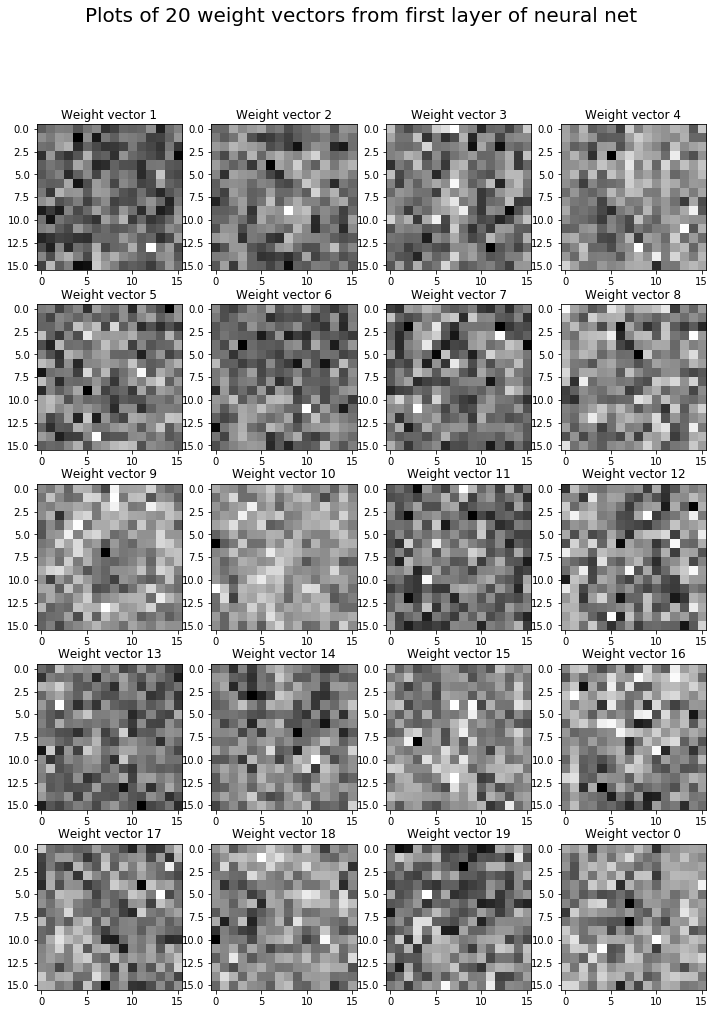

In [207]:
nn.weights[0].T.shape

fig = plt.figure(figsize=(12,16))
gs = fig.add_gridspec(5, 4)
fig.suptitle('Plots of 20 weight vectors from first layer of neural net',fontsize=20)

for idx, weight in enumerate(nn.weights[0].T):
    #print(weight.shape)
    f_ax1 = fig.add_subplot(gs[idx-1])
    plt.title('Weight vector %d'%idx)
    plt.imshow(weight.detach().numpy().reshape(16,16),cmap='gray')


In [114]:
nn = neural_network(cvnn.__params[0], scale=0.1, p=0.1, lr=0.5, lam=0.01)
nn.fit(X_tr,y_tr)

y_pred = nn.predict(X=X_te)

y_predy_pred


C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


array([[0.30935973, 0.01811895, 0.17236249, ..., 0.02045672, 0.07950214,
        0.0163182 ],
       [0.00973882, 0.28093436, 0.01615857, ..., 0.21281578, 0.06666806,
        0.06551235],
       [0.00973882, 0.28093436, 0.01615857, ..., 0.21281578, 0.06666806,
        0.06551235],
       ...,
       [0.00973882, 0.28093436, 0.01615857, ..., 0.21281578, 0.06666806,
        0.06551235],
       [0.00973883, 0.28093436, 0.01615858, ..., 0.2128158 , 0.06666808,
        0.06551237],
       [0.0416556 , 0.17758961, 0.05578187, ..., 0.15418373, 0.12379856,
        0.06972376]], dtype=float32)

In [121]:
np.count_nonzero(np.argmax(y_pred,axis=1)==np.argmax(y_te,axis=1))

155